In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from meteostat import Hourly, Point, Stations
import sklearn as sk
import requests
import time

from darts import TimeSeries
from darts.models import TFTModel, RNNModel, XGBModel
from darts.metrics import mse, mae, rmse, mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models.torch import QuantileRegression
from darts.explainability import TFTExplainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import EarlyStopping
from IPython.display import clear_output
import torch
import os
import openpyxl
import pytz
import gc
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import json
#import folium





In [25]:
xls = pd.ExcelFile("data/svk/timvarden-2025.xlsx", engine="openpyxl")
print("Available sheets:", xls.sheet_names)

Available sheets: ['generis_temp']


In [26]:
def create_column_names(fpath, name_rows=None):
    """
    Creates column names from the first row(s) of an Excel file.

    This function reads an Excel file and extracts column names based on the specified number of rows.

    :param fpath: 
        Path to the Excel file.
    :param name_rows: 
        Number of rows to use for creating column names. If None, defaults to using the first row only.
    :return: 
        A list of column names extracted from the file.
    """
    new_list = []
    name_pd = pd.read_excel(fpath, nrows=name_rows, header=None, engine="openpyxl")
    #print("HI2")
    name_pd = name_pd.T
    for _, row in name_pd.iterrows():
        parts = [str(cell).strip() for cell in row if pd.notna(cell)]
        combined = " ".join(parts)
        new_list.append(combined)
    new_list[0] = "timestamp"    
    #print(len(new_list))
    return new_list


def rename_columns(df, column_names):
    """
    Rename columns of the DataFrame to the provided column names.
    
    :param df: 
        DataFrame to rename columns for
    :param column_names: 
        List of new column names
    """   
    # Check if the number of columns in df matches the length of column_names
    if len(df.columns) != len(column_names):
        raise ValueError(f"Number of columns in DataFrame ({len(df.columns)}) does not match length of column_names ({len(column_names)})")
    
    for i, x in enumerate(df):
        df.rename(columns={x: column_names[i]}, inplace=True)
    return df


def load_df(file_path:str, sheet_name:str=None, skiprows:int=None, name_rows:int=None):
    """
    Load a DataFrame from an Excel file, renaming columns based on the first row.

    :param file_path: 
        Path to the Excel file
    :param sheet_name: 
        Name of the sheet to load
    :param skiprows: 
        Number of rows to skip at the start of the sheet
    :param name_rows:  
        Number of rows to read for column names
    """
    #print(file_path)
    #print(sheet_name)
    column_names = create_column_names(file_path, name_rows=name_rows)
    df = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl", skiprows=skiprows)
    df = rename_columns(df, column_names)
    return df


def fix_timestamp(df):
    """
    Fix the timestamp column in the DataFrame.
    """

    df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', dayfirst=True)
    return df


def remove_rows(df, span):
    """
    Remove rows from the DataFrame based on a specified span.
    
    :param df: 
        DataFrame to remove rows from
    :param span: 
        Span of rows to remove
    """
    df = df.copy()
    df = df.drop(df.index[:span], axis=0)
    df = df.reset_index(drop=True)
    return df

def fetch_excel_data(start, end, sheet_name:str=None, skiprows:int=None, name_rows:int=None, remove = False):
    """
    Fetch data from an Excel file and return a DataFrame.
    
    :param file_path: 
        Path to the Excel file
    :param sheet_name: 
        Name of the sheet to load
    :param skiprows: 
        Number of rows to skip at the start of the sheet
    :param name_rows:  
        Number of rows to read for column names
    """
    if start != end:
        all_years = []
        for i in range(start, end):
            file_path = f"data/svk/timvarden-{i}.xlsx"
            sheet_name = "generis_temp"
            dataframe = load_df(file_path, sheet_name=sheet_name, skiprows=skiprows, name_rows=name_rows)
            all_years.append(dataframe)
        df = pd.concat(all_years, ignore_index=True)
    else:
        #print("hi")
        file_path = f"data/svk/timvarden-{start}.xlsx"
        sheet_name = "generis_temp"
        df = load_df(file_path, sheet_name=sheet_name, skiprows=skiprows, name_rows=name_rows)

    #df = load_df(file_path, sheet_name=sheet_name, skiprows=skiprows, name_rows=name_rows)

    df = fix_timestamp(df)
    if remove:
        df = remove_rows(df, 24)

    return df

# Load the Excel file
"""all_years = []
for i in range(2021, 2025):
    file_path2 = f"data/svk/timvarden-{i}.xlsx"
    sheet_name = "generis_temp"
    dataframe = load_df(file_path2, sheet_name=sheet_name, skiprows=4, name_rows=4)
    all_years.append(dataframe)"""
    #print(dataframe)
#print(len(all_years))

dataframe_elprod = fetch_excel_data(2021, 2025, sheet_name="generis_temp", skiprows=4, name_rows=4, remove = True)
dataframe_elprod_25 = fetch_excel_data(2025, 2025, sheet_name="generis_temp", skiprows=4, name_rows=4)




In [27]:
def from_csv_to_df(file_path:str, sep:str = ";", header:int = 0, name_rows:int = None):
    """
    Load a DataFrame from a CSV file, renaming columns based on the first row.

    :param file_path: 
        Path to the CSV file
    :param sep: 
        Separator used in the CSV file
    :param header: 
        Row number to use as the column names
    :param name_rows:  
        Number of rows to read for column names
    """
    #find all files
    os.chdir("data/csv")
    column_names = create_column_names(file_path, name_rows=name_rows)
    df = pd.read_csv(file_path, sep=sep, header=header)
    df = rename_columns(df, column_names)
    return df

In [28]:
# Create Point for Vancouver, BC

def fetch_stations(country:str = 'SE', region:str = 'BD', latjavel:float = None, longjavel:float = None, radius:int = 10):
    """
    Fetch weather stations for a given country and region.
    
    :param country: 
        Country code (e.g., 'SE' for Sweden)
    :param region: 
        Region code (e.g., 'BD' for Norrland)
    :param latitude:
        Latitude of the location (optional)
    :param longitude:
        Longitude of the location (optional)
    :param radius:
        Radius in kilometers to search for nearby stations (optional)
    """
    stations = Stations()
    if latjavel and longjavel:
        location = Point(lat = latjavel, lon = longjavel)
        #print(location)
        stations = stations.nearby(latjavel, longjavel, radius=radius)
        return stations.fetch()
    stations = Stations()
    stations = stations.region(country, region)
    
    return stations.fetch()

SE1 = ['BD', 'AC']
stations = []
for region in SE1:
    stations.append(fetch_stations(country='SE', region=region))
SE1 = pd.concat(stations, ignore_index=False)  
#SE1

SE3 = ['AB', 'C', 'D', 'U', 'W', 'T', 'S', 'E', 'VG', 'F', 'I']
stations = []  
for region in SE3:
    stations.append(fetch_stations(country='SE', region=region))
SE3 = pd.concat(stations, ignore_index=False)
SE3_stations = SE3.copy()
notSE1drop = SE1[SE1['name'].isin(['Vilhelmina / Forsnäs', 'Hemavan Tarnaby', 'Umea Airport'])].index
SE1 = SE1.drop(notSE1drop)
SE1_stations = SE1.copy()


In [29]:
def sort_dataframe(df):
    timestamp = df['timestamp']  # Save the timestamp column
    sorted_df = df.drop(columns='timestamp').sort_index(axis=1)  # sort columns except timestamp

    sorted_df.insert(0, 'timestamp', timestamp)  # insert it at position 0
    df = sorted_df
    return df


In [30]:
def active_stations(station, start_date, cutoff_date):
    #if station['hourly_start'] or station['hourly_end'] == NaT:

    station = station[station['hourly_end'] > cutoff_date]
    station = station[station['hourly_start'] < start_date]
    
    return station

stationsSE_3 = active_stations(SE3, start_date = pd.Timestamp('2021-01-01'), cutoff_date = pd.Timestamp('2024-12-31'))
#stations_old = active_stations(old_style, start_date = pd.Timestamp('2021-01-01'), cutoff_date = pd.Timestamp('2024-12-31'))
stationsSE_1 = active_stations(SE1, start_date = pd.Timestamp('2021-01-01'), cutoff_date = pd.Timestamp('2024-12-31'))
stationsSE1_25 = active_stations(SE1, start_date = pd.Timestamp('2025-01-01'), cutoff_date = pd.Timestamp('2025-02-28'))
stationsSE3_25 = active_stations(SE3, start_date = pd.Timestamp('2025-01-01'), cutoff_date = pd.Timestamp('2025-02-28'))


#stationsSE_1

In [31]:

def fetch_data(station_id, start, end):
    #print(station_id)
    data = Hourly(station_id, start, end)
    #print(data)
    data = data.fetch()
    #print(data)
    return data

def aggregate_data(data, freq='D'):
    data = data.resample(freq).mean()
    return data

start = datetime(2014, 1, 2)
end = datetime(2024, 12, 31, 23, 59)
cutoff_date = datetime(2021, 1, 2)

def aggregate_pandaframes(all_stations, start, end):
    data = {}

    for station in all_stations.iterrows():
        #print(station)
        data[station[1]['name']] = fetch_data(station[0], start, end)
        #data_25_SE1[station[1]['name']] = fetch_data(station[0], pd.Timestamp('2025-01-01'), pd.Timestamp('2025-02-28T23:59:00'))
    return data


data_21_24_SE1 = aggregate_pandaframes(stationsSE_1, cutoff_date, end)
#print(type(data_21_24_SE1))
data_25_SE1 = aggregate_pandaframes(stationsSE_1, pd.Timestamp('2025-01-01'), pd.Timestamp('2025-02-28T23:59:00'))
data_21_24_SE3 = aggregate_pandaframes(stationsSE_3, cutoff_date, end)
data_25_SE3 = aggregate_pandaframes(stationsSE_3, pd.Timestamp('2025-01-01'), pd.Timestamp('2025-02-28T23:59:00'))

    


In [32]:
def create_dataframe(data_dict, ELOM = 'SE1'):
    """
    Create a DataFrame from a dictionary of DataFrames.
    
    :param data_dict:
        Dictionary where keys are station names and values are DataFrames
    :return:
        Merged DataFrame with 'time' as the index and columns for each station's data
    """
    # Removed Coco becuase it was coco and prcp to mutch NaN, rhum, dwpt
    dfs = []  # List of DataFrames to merge
    variables = ["wspd", "temp", "wdir", "wpgt", "pres"]

    for key, df in data_dict.items():

        for v in variables:
            temp_df = df[[v]].copy()
            temp_df.rename(columns={v: key + " " + v}, inplace=True)  # Rename variable to the location + variable name, eg. Vidsel Airport wspd
            dfs.append(temp_df)
            
    # Merge all DataFrames on 'time'
    merged_df = dfs[0]
    for temp_df in dfs[1:]:
        merged_df = pd.merge(merged_df, temp_df, on="time", how="outer")

    # Sort by time and rename time to 'timestamp'
    merged_df.sort_values("time", inplace=True)
    merged_df =  merged_df.reset_index().rename(columns={"time": "timestamp"})
    
    return merged_df


def merge_dataframes(df1, df2, var = 'SE1'):
    # Merge the two DataFrames on 'timestamp', keeping all rows from both DataFrames, and only keeping the 'Vindkraft produktion SE1 MWh' column from df2
    merged_df = pd.merge(df1, df2[['timestamp',f'Vindkraft produktion {var} MWh']], on="timestamp", how="outer")
  
    return merged_df

def remove_columns(df, columns_to_remove):
    """
    Remove specified columns from the DataFrame.
    
    :param df: 
        DataFrame to remove columns from
    :param columns_to_remove: 
        List of column names to remove
    """
    if all(columns_to_remove) in df.columns:
        df.drop(columns=columns_to_remove, inplace=True, errors='ignore')
    else:
        for name in columns_to_remove:
            if name in df.columns:
                df.drop(columns=name, inplace=True, errors='ignore')
    return df


pd.set_option('display.max_columns', None)
windspeed_24_SE1 = create_dataframe(data_21_24_SE1) # 35064 rows
windspeed_25_SE1 = create_dataframe(data_25_SE1) 
windspeed_24_SE3 = create_dataframe(data_21_24_SE3) # 35064 rows
SE1 = merge_dataframes(windspeed_24_SE1, dataframe_elprod, var = 'SE1')
SE1_25 = merge_dataframes(windspeed_25_SE1, dataframe_elprod_25, var = 'SE1')
SE3 = merge_dataframes(windspeed_24_SE3, dataframe_elprod, var = 'SE3')
SE1 = remove_columns(SE1, ('Vilhelmina', 'Umea', 'Hemavan'))

windspeed_25_SE3 = create_dataframe(data_25_SE3)
SE3_25 = merge_dataframes(windspeed_25_SE3, dataframe_elprod_25, var = 'SE3')


In [33]:
def convert_to_mps(df):
    """
    Converts wind speed columns from km/h to m/s.
    This function iterates through the DataFrame columns and converts any column containing 'wspd' or 'wpgt' from km/h to m/s.
    """
    # Convert wind speed from km/h to m/s
    for column in df.columns:
        if 'wspd' in column:
            df[column] = df[column] / 3.6  # Convert km/h to m/s
        if 'wpgt' in column:
            df[column] = df[column] / 3.6  # Convert km/h to m/s

    return df

SE1 = convert_to_mps(SE1)
SE1_25 = convert_to_mps(SE1_25)
SE3 = convert_to_mps(SE3)
SE3_25 = convert_to_mps(SE3_25)


In [34]:
def vectorize_wind(df):  
    """
    Converts wind speed and direction columns to x and y components."""  
    df = df.copy()
    cols = df.columns[df.columns.str.contains('wspd|wpgt', case=False, regex=True)].copy()
    winddir_rad = df.columns[df.columns.str.contains('wdir', case=False, regex=True)].copy()
    #print(type(winddir_rad))

    for dir in winddir_rad:
        df[dir] = df[dir] * np.pi / 180

    remove_cols = []

    for sensor in cols:
        name = sensor[:-4] + 'wdir'
        #print(sensor)
        if 'wpgt' in sensor:
            df[sensor + '_x'] = df[sensor] * np.cos(df[name]) #vidsel wpgt -> vidsel wdir
            df[sensor + '_y'] = df[sensor] * np.sin(df[name])
            remove_cols.append(sensor)
            
        if 'wspd' in sensor:
            df[sensor + '_x'] = df[sensor] * np.cos(df[name])
            df[sensor + '_y'] = df[sensor] * np.sin(df[name])
            remove_cols.append(sensor)

        if sensor[:-4] + 'wdir' not in remove_cols:
            remove_cols.append(name)

    df.drop(columns=remove_cols, inplace=True)
    df = sort_dataframe(df)   

    return df

def vectorize_future_wind(df):

    df = df.copy()
    cols = df.columns[df.columns.str.contains('wspd|wpgt', case=False, regex=True)].copy()
    winddir_sin = df.columns[df.columns.str.contains('sin', case=False, regex=True)].copy()
    winddir_cos = df.columns[df.columns.str.contains('cos', case=False, regex=True)].copy()

    remove_cols = []

    for sensor in cols:
        name = sensor[:-4]
        sin = name+f"wdir_sin"
        cos = name+f"wdir_cos"

        if 'wpgt' in sensor:
            #if sensor in winddir_sin:

            df[sensor + '_x'] = df[sensor] * df[cos] #vidsel wpgt -> vidsel wdir
            df[sensor + '_y'] = df[sensor] * df[sin]
            remove_cols.append(sensor)
            
        if 'wspd' in sensor:
            df[sensor + '_x'] = df[sensor] * df[cos] #vidsel wpgt -> vidsel wdir
            df[sensor + '_y'] = df[sensor] * df[sin]
            remove_cols.append(sensor)

        if cos not in remove_cols or sin not in remove_cols:
            remove_cols.append(cos) 
            remove_cols.append(sin)
            """if sensor[:-4] + 'wdir' not in remove_cols:
                remove_cols.append(name)"""

    df.drop(columns=remove_cols, inplace=True)
    df = sort_dataframe(df)   

    return df

In [35]:
SE1 = vectorize_wind(SE1)
SE1_25 = vectorize_wind(SE1_25)
SE3 = vectorize_wind(SE3)
SE3_25 = vectorize_wind(SE3_25)

(np.float64(-5.0),
 np.float64(10.148991010209143),
 np.float64(-13.856406460551018),
 np.float64(5.033461848729063))

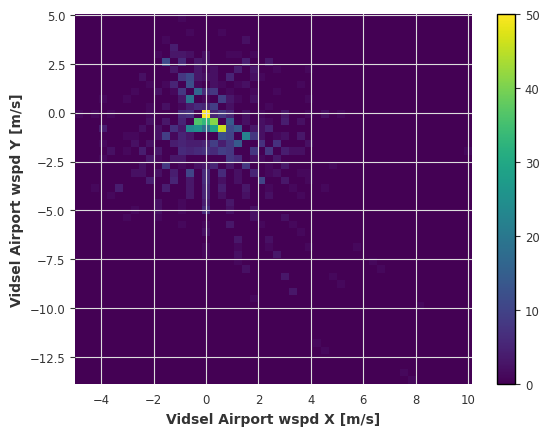

In [36]:
plt.hist2d(SE1_25['Vidsel Airport wspd_x'], SE1_25['Vidsel Airport wspd_y'], bins=(50, 50), vmax=50)
plt.colorbar()
plt.xlabel('Vidsel Airport wspd X [m/s]')
plt.ylabel('Vidsel Airport wspd Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [37]:
def cyclic_encoding_paragraphryttare_galore(df, column_name):
    # Create cyclic encoding for the specified column
    
    timestamp_s = df[column_name].map(pd.Timestamp.timestamp)

    day = 24*60*60
    week = day*7
    year = day*(365.2425)
    #month = year / 12

    df['hour_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['hour_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

    df['dayofweek_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
    df['dayofweek_cos'] = np.cos(timestamp_s * (2 * np.pi / week))

    df['dayofyear_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['dayofyear_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    for v in df.columns:
        if "wdir" in v:
            df[v + '_sin'] = np.sin(np.deg2rad(df[v]))
            df[v + '_cos'] = np.cos(np.deg2rad(df[v]))
            df.drop(v, axis=1, inplace=True)

    timestamp = df['timestamp']  # Save the timestamp column
    sorted_df = df.drop(columns='timestamp').sort_index(axis=1)  # sort columns except timestamp

    sorted_df.insert(0, 'timestamp', timestamp)  # insert it at position 0
    df = sorted_df
    #df = df[sorted(df.columns)]

    return df
    

SE1 = cyclic_encoding_paragraphryttare_galore(SE1, 'timestamp')
SE1_25 = cyclic_encoding_paragraphryttare_galore(SE1_25, 'timestamp')
SE3 = cyclic_encoding_paragraphryttare_galore(SE3, 'timestamp')
SE3_25 = cyclic_encoding_paragraphryttare_galore(SE3_25, 'timestamp')
      

In [38]:
# --- 2. Hjälpfunktioner för log-transform ---
def log_transform(ts: TimeSeries) -> TimeSeries:
    return ts.map(lambda x: np.log1p(x))

def inverse_log_transform(ts: TimeSeries) -> TimeSeries:
    return ts.map(lambda x: np.expm1(x))

def signed_log1p(ts:TimeSeries) -> TimeSeries:
    return ts.map(lambda x: np.sign(x) * np.log1p(np.abs(x)))

In [39]:
class PersistentLivePlotCallback(Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

        # Enable interactive plotting
        plt.ion()
        self.fig, self.ax = plt.subplots(figsize=(10, 5))
        self.line1, = self.ax.plot([], [], label="Train Loss", marker='o')
        self.line2, = self.ax.plot([], [], label="Validation Loss", marker='x')
        self.ax.set_title("Training Progress")
        self.ax.set_xlabel("Epoch")
        self.ax.set_ylabel("Loss")
        self.ax.legend()
        self.ax.grid(True)
        self.fig.show()

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss")
        val_loss = trainer.callback_metrics.get("val_loss")

        self.train_losses.append(train_loss.item() if train_loss else None)
        self.val_losses.append(val_loss.item() if val_loss else None)

        self.line1.set_data(range(len(self.train_losses)), self.train_losses)
        self.line2.set_data(range(len(self.val_losses)), self.val_losses)
        self.ax.relim()
        self.ax.autoscale_view()

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

        if val_loss:
            print(f"📉 Epoch {trainer.current_epoch + 1}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
        else:
            print(f"📉 Epoch {trainer.current_epoch + 1}: train_loss={train_loss:.4f}")


start=2025-05-22T00:00:00, end=2025-05-29T00:00:00
            timestamp              timestampUTC  mba        total  \
0 2022-11-02 01:00:00 2022-11-02 00:00:00+00:00  SE1  2938.370388   
1 2022-11-02 02:00:00 2022-11-02 01:00:00+00:00  SE1  2644.592029   
2 2022-11-02 03:00:00 2022-11-02 02:00:00+00:00  SE1  2790.079644   
3 2022-11-02 04:00:00 2022-11-02 03:00:00+00:00  SE1  3168.189472   
4 2022-11-02 05:00:00 2022-11-02 04:00:00+00:00  SE1  3386.610306   

          wind  windOffshore    solar        hydro    thermal  nuclear  \
0   981.167992             0  0.00005  1927.082546  30.105860        0   
1   929.036739             0  0.00000  1685.248960  30.296720        0   
2  1159.993508             0  0.00014  1600.584024  29.496232        0   
3  1148.260917             0  0.00016  1995.923539  23.998696        0   
4  1116.217744             0  0.00026  2251.154270  19.233672        0   

     other  energyStorage  
0  0.01394              0  
1  0.00961              0  
2  0.

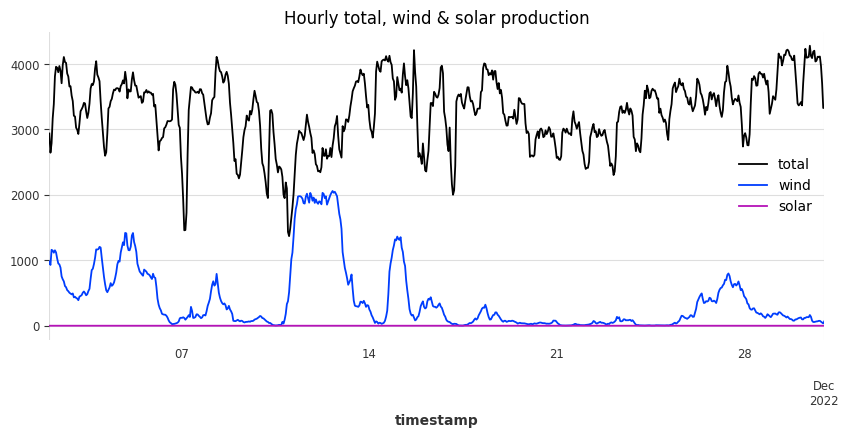

In [40]:
from datetime import datetime, timedelta

# Get the current date and time
now = datetime.now()

# Subtract one day from the current date
yesterday = now - timedelta(days=1)
seven_days_ago = now - timedelta(days=8)

# Format the start and end date as per your requirement
start = seven_days_ago.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
end = yesterday.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()

print(f"start={start}, end={end}")


def fetch_esett_aggregate(
    mba_codes: list[str],
    start: str,
    end: str,
    resolution: str = "hour",
    columns: list = [
                    "timestamp", "timestampUTC", "mba", "total",
                    "wind", "windOffshore", "solar", "hydro",
                    "thermal", "nuclear", "other", "energyStorage"
                        ]
) -> pd.DataFrame:
    """
    Fetch aggregated production per MBA from eSett Open Data.

    Args:
        mba_codes: list of MBA EIC codes, e.g. ["10Y1001A1001A44P"]
        start:     ISO8601 UTC start, e.g. "2022-11-02T00:00:00.000Z"
        end:       ISO8601 UTC end,   e.g. "2022-12-01T00:00:00.000Z"
        resolution: one of "year","month","week","day","hour" (default "hour")

    Returns:
        DataFrame with columns:
          ['timestamp', 'timestampUTC', 'mba', 'total',
           'wind', 'windOffshore', 'solar', 'hydro',
           'thermal', 'nuclear', 'other','energyStorage']
    """
    base_url = "https://api.opendata.esett.com"
    endpoint = "/EXP16/Aggregate"

    # build query params; lists become repeated ?mba=...&mba=...
    params = {
        "start": str(start),
        "end":   str(end),
        "resolution": resolution,
        "mba": mba_codes
    }

    resp = requests.get(base_url + endpoint, params=params)
    resp.raise_for_status()               # blow up if we get 4xx/5xx
    data = resp.json()                   # this is a list of dicts

    # normalize into a flat table
    df = pd.json_normalize(data)

    # parse timestamps
    df["timestamp"]    = pd.to_datetime(df["timestamp"])
    df["timestampUTC"] = pd.to_datetime(df["timestampUTC"])

    # reorder columns if you like
    cols = columns
    return df[cols]

# ── example usage ──────────────────────────────────────────────────────────────

# fetch one month of hourly production for a single MBA
df = fetch_esett_aggregate(
    mba_codes=["10Y1001A1001A44P"],
    #mba_codes=["10Y1001A1001A46L"],

   # start = start+'.000Z',
   # end = end+'.000Z',
    start="2022-11-02T00:00:00.000Z",
    end=  "2022-12-01T00:00:00.000Z",
    resolution="hour",
)

print(df.head())
#              timestamp              timestampUTC                  mba  total  wind  windOffshore  solar  hydro  thermal  nuclear  other  energyStorage
# 0 2022-11-02 00:00:00 2022-11-02T00:00:00.000Z  10Y1001A1001A44P      27     3            0      2     12        5        0      5              0
# 1 2022-11-02 01:00:00 2022-11-02T01:00:00.000Z  10Y1001A1001A44P      25     2            0      1     11        4        0      7              0
# ...

# now you can set 'timestamp' as index, resample, plot, feed into your model, etc.
df.set_index("timestamp", inplace=True)
df[["total", "wind", "solar"]].plot(figsize=(10,4))
plt.title("Hourly total, wind & solar production")
plt.show()


In [151]:
def interpolate_weather_df1(df, split_date = False):
    df_interp = df.copy()



    ### ========== TURN WIND DIRECTION INTO COS / SIN RADIANS =========
    columns_to_remove = []
    winddir_rad = df_interp.columns[df_interp.columns.str.contains('wdir', case=False, regex=True)].copy()
    for dir in winddir_rad:
        df_interp[dir+'_sin'] = np.sin(df_interp[dir] * np.pi / 180)
        df_interp[dir+'_cos'] = np.cos(df_interp[dir] * np.pi / 180)
        columns_to_remove.append(dir)

    df_interp.drop(columns=columns_to_remove, inplace=True)

    ### ========== INTERPOLATE ALL DATA THAT IS MISSING ============
    for col in df_interp.columns:
        col_lower = col.lower()

        if 'wdir' in col_lower:
            #print(col)
            df_interp[col].interpolate(method='linear', limit_direction = 'both', inplace = True)

        elif any(x in col_lower for x in ['wspd', 'wpgt', 'temp', 'pres']):
            # Handle continuous scalars with pchip
            try:
                df_interp[col].interpolate(method='pchip', limit_direction = 'both', inplace = True)
            except:
                # Fall back if pchip fails (e.g. too few points)

                ### TODO: TÄNK PÅ WPGT SOM SAKNAS HELT PÅ VISSA STÄLLEN [check]

               df_interp[col].interpolate(method='linear',limit_direction = 'both', inplace = True)


    ### ======= WHEN ALL IS SAID AND DONE, RAMOVE THE LAST HOUR ========
    if split_date:
        df_interp = df_interp[df_interp['timestamp'] <= split_date]



    return df_interp


In [ ]:
import numpy as np
import pandas as pd

def interpolate_weather_df(df, split_date=False):
    df_interp = df.copy()

    # 1. Resample till 1h
    df_interp['timestamp'] = pd.to_datetime(df_interp['timestamp'])
    df_interp.set_index('timestamp', inplace=True)
    df_interp = df_interp.resample('1H').asfreq()
    df_interp.reset_index(inplace=True)

    # 2. Vindriktning → sin/cos
    columns_to_remove = []
    winddir_cols = df_interp.columns[df_interp.columns.str.contains('wdir', case=False, regex=True)]
    for col in winddir_cols:
        df_interp[col + '_sin'] = np.sin(np.radians(df_interp[col]))
        df_interp[col + '_cos'] = np.cos(np.radians(df_interp[col]))
        columns_to_remove.append(col)
    df_interp.drop(columns=columns_to_remove, inplace=True)

    # 3. Interpolera variabler baserat på typ
    for col in df_interp.columns:
        col_lower = col.lower()
        valid_points = df_interp[col].notna().sum()

        # Temperatur (kan vara negativ)
        if 'temp' in col_lower:
            if valid_points >= 4:
                df_interp[col] = df_interp[col].interpolate(method='pchip', limit_direction='both')
            elif valid_points >= 2:
                df_interp[col] = df_interp[col].interpolate(method='linear', limit_direction='both')

        # Luftryck (ska vara rimligt, >800)
        elif 'pres' in col_lower:
            if valid_points >= 4:
                df_interp[col] = df_interp[col].interpolate(method='pchip', limit_direction='both')
            elif valid_points >= 2:
                df_interp[col] = df_interp[col].interpolate(method='linear', limit_direction='both')
            df_interp[col] = df_interp[col].clip(lower=800)

        # Vindhastighet (mjukt)
        elif 'wspd' in col_lower:
            if valid_points >= 3:
                df_interp[col] = df_interp[col].interpolate(method='pchip', limit_direction='both')
            elif valid_points >= 2:
                df_interp[col] = df_interp[col].interpolate(method='linear', limit_direction='both')
            df_interp[col] = df_interp[col].clip(lower=0)

        # Vindbyar (spikigt, inga negativa värden)
        elif 'wpgt' in col_lower:
            if valid_points >= 2:
                df_interp[col] = df_interp[col].interpolate(method='linear', limit_direction='both')
            df_interp[col] = df_interp[col].clip(lower=0)

        # Vindriktning sin/cos – kan vara negativ, alltid linear
        elif 'sin' in col_lower or 'cos' in col_lower:
            if valid_points >= 2:
                df_interp[col] = df_interp[col].interpolate(method='linear', limit_direction='both')

    # 4. Begränsa slutdatum om det anges
    if split_date:
        df_interp = df_interp[df_interp['timestamp'] <= split_date]

    return df_interp


In [154]:
from datetime import datetime, timedelta

def call_api(station_id, EICcodes, stations, current = True, train = False, 
             start:datetime = '2021-01-02', 
             end:datetime = '2025-01-01', 
             val_start:datetime = '2025-01-01', 
             val_end:datetime = None):

    time_col = "timestamp"

    # Scalers
    target_scaler = Scaler()
    covariate_scaler = Scaler()

    # Get the current date and time
    now = datetime.now()
    if current:
    # Subtract one day from the current date
        end = now - timedelta(days=1)
        #three_days_ago = now - timedelta(days=4+1+1)
        start = now - timedelta(days=8+1)
        #future = now + timedelta(days=2-1)
    elif train:
        start = pd.Timestamp(start)
        end = pd.Timestamp(end)
        val_start = pd.Timestamp(val_start)
        if val_end is not None:
            val_end = pd.Timestamp(val_end)
        else:
            val_end = now - timedelta(days=3)
    else:
        end = now - timedelta(days=3)
        #three_days_ago = now - timedelta(days=8)
        start = now - timedelta(days=10)
        #future = now 
        
    start = start.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
    end = end.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
    #future = future.replace(hour=23, minute=0, second=0, microsecond=0).isoformat()

    ### ========== LOADING PRODUCTION DATA FROM ESATT ===========
    MBA = EICcodes[station_id]
    
    cols = [
        "timestamp", "timestampUTC", "mba", "total",
        "wind", "windOffshore", "solar", "hydro",
        "thermal", "nuclear", "other", "energyStorage"
            ]
    columns = ['timestampUTC', 'wind']

    datorfrejm = fetch_esett_aggregate(
        mba_codes=[MBA],
        start= start + ".000Z",           # Time start
        end=  end + ".000Z",           # Time end
        resolution="hour",
        columns = columns,
    )
    if train:
        val_start = val_start.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
        val_end = val_end.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
        remove_time = now - timedelta(days=4)
        remove_time = remove_time.replace(hour=23, minute=0, second=0, microsecond=0).isoformat()
        
        valpow = fetch_esett_aggregate(
        mba_codes=[MBA],
        start= val_start + ".000Z",           # Time start
        end=  val_end + ".000Z",           # Time end
        resolution="hour",
        columns = columns,
        )

        stations_ex = {'SE1': windspeed_24_SE1,
                    'SE3': windspeed_24_SE3}
        df = rename_columns(datorfrejm, ['timestamp', f'Vindkraft produktion {station_id} MWh'])
        df = fix_timestamp(df)
        df2 = stations_ex[station_id].copy()
        df2 = fix_timestamp(df2)
        df2['timestamp'] = df2['timestamp'].dt.tz_localize ('UTC')
        #df2 = stations[station_id]['timestamp'].dt.tz_localize('Europe/Stockholm').tz_convert('UTC')
        df = pd.merge(df2, df, on="timestamp", how="outer")
        df = interpolate_weather_df(df)
        df = convert_to_mps(df)
        df = vectorize_future_wind(df)
        df = cyclic_encoding_paragraphryttare_galore(df, 'timestamp')

        valpow = rename_columns(valpow, ['timestamp', f'Vindkraft produktion {station_id} MWh'])
        stations_val = active_stations(stations[station_id], start_date = pd.Timestamp(val_start[:-9]), cutoff_date = pd.Timestamp(val_start[:-9]))
        stations_val_dict = aggregate_pandaframes(stations_val, pd.Timestamp(val_start[:-9]), pd.Timestamp(val_end[:-9]))
        stations_val = create_dataframe(stations_val_dict) 
        bad_cols = ['Vilhelmina', 'Umea', 'Hemavan']

        if station_id == 'SE1' and any(col in stations_val.columns for col in bad_cols):
            # keep only those that actually exist
            to_drop = [col for col in bad_cols if col in stations_val.columns]
            stations_val = stations_val.drop(columns=to_drop)
        stations_val = fix_timestamp(stations_val)
        stations_val['timestamp'] = stations_val['timestamp'].dt.tz_localize ('UTC')
        stations_val = pd.merge(stations_val, valpow, on="timestamp", how="outer")
        stations_val = interpolate_weather_df(stations_val, remove_time)
        stations_val = vectorize_future_wind(stations_val)
        stations_val = convert_to_mps(stations_val)
        stations_val = cyclic_encoding_paragraphryttare_galore(stations_val, 'timestamp')

        return df, stations_val

    target = TimeSeries.from_dataframe(datorfrejm, time_col='timestampUTC', value_cols = ['wind']).astype("float32")
    #return target.to_dataframe(), None, None, 
    #return datorfrejm, None, None
    ### ========= LOADING STATIONS FROM METEOSTAT ===========
    # Subtract one day from the current date
    if current:
        yesterday = now - timedelta(days=1+1+1)
        true_yesterday = now - timedelta(days=1+1)
        three_days_ago = now - timedelta(days=4+1)
        seven_days_ago = now - timedelta(days=8+1)
        future = now + timedelta(days=1)
        True_Future = now
    else:
        yesterday = now - timedelta(days=2+2)
        true_yesterday = now - timedelta(days=1+2)
        three_days_ago = now - timedelta(days=4+2)
        seven_days_ago = now - timedelta(days=8+2)
        future = now - timedelta(days=1)
        True_Future = now - timedelta(days=2)
    #yesterday = yesterday.astimezone()

    #return yesterday
    # Format the start and end date as per your requirement
    start = seven_days_ago.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
    three_days_ago = three_days_ago.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
    end = yesterday.replace(hour=23, minute=0, second=0, microsecond=0).isoformat()
    yesterday = true_yesterday.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
    future = future.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
    True_Future = True_Future.replace(hour=23, minute=0, second=0, microsecond=0).isoformat()

    stations_Past = active_stations(stations[station_id], start_date = pd.Timestamp(start[:-9]), cutoff_date = pd.Timestamp(three_days_ago[:-9]))
    #print(type(stations_Past))
    #return stations_Past
    stations_Future = active_stations(stations[station_id], start_date = pd.Timestamp(start[:-9]), cutoff_date = pd.Timestamp(three_days_ago[:-9]))
    stations_dict_past = aggregate_pandaframes(stations_Past, pd.Timestamp(start[:-9]), pd.Timestamp(end))
    stations_dict_future = aggregate_pandaframes(stations_Future, pd.Timestamp(yesterday), pd.Timestamp(future))
    stations_Past = create_dataframe(stations_dict_past)
    #stations_Past = merge_dataframes(create_dataframe(stations_dict_past), target, var = station_id)
    stations_Future = create_dataframe(stations_dict_future)

    bad_cols = ['Vilhelmina', 'Umea', 'Hemavan']

    if station_id == 'SE1' and any(col in stations_Past.columns for col in bad_cols):
        # keep only those that actually exist
        to_drop = [col for col in bad_cols if col in stations_Past.columns]
        stations_Past = stations_Past.drop(columns=to_drop)
    
 
    stations_Future = interpolate_weather_df(stations_Future, pd.Timestamp(True_Future))

    stations_Past = convert_to_mps(stations_Past)
    stations_Future = convert_to_mps(stations_Future)
    raw_past = stations_Past.copy()
    raw_future = stations_Future.copy()
  
    #return raw_future, stations_Future
    
    stations_Past = vectorize_wind(stations_Past)
    stations_Future = vectorize_future_wind(stations_Future)
    
    stations_Past = cyclic_encoding_paragraphryttare_galore(stations_Past, 'timestamp')
    stations_Future = cyclic_encoding_paragraphryttare_galore(stations_Future, 'timestamp') 

    #return stations_Past, None, None
    cyclical_series_Past = TimeSeries.from_dataframe(stations_Past, time_col=time_col, value_cols=['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']).astype("float32")
    cyclical_series_Future = TimeSeries.from_dataframe(stations_Future, time_col=time_col, value_cols=['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']).astype("float32")

    # Drop target from covariates
    covariate_cols_past = [col for col in stations_Past.columns if col not in [time_col, 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']]
    covariate_cols_future = [col for col in stations_Future.columns if col not in [time_col, 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']]

    past_cov = TimeSeries.from_dataframe(stations_Past, time_col=time_col, value_cols=covariate_cols_past).astype("float32")
    future_cov = TimeSeries.from_dataframe(stations_Future, time_col=time_col, value_cols=covariate_cols_future).astype("float32")

    #return covariate_scaler, None, None
    past_cov_scaled = covariate_scaler.fit_transform(past_cov)
    future_cov_scaled = covariate_scaler.transform(future_cov)
    past_target_log = log_transform(target) 

    past_cov_scaled = past_cov_scaled.stack(cyclical_series_Past)
    future_cov_scaled = future_cov_scaled.stack(cyclical_series_Future)
    future_cov_scaled = past_cov_scaled.concatenate(future_cov_scaled)
    
    past_cov_scaled = past_cov_scaled.stack(past_target_log)
    

    return past_cov_scaled, future_cov_scaled, target, past_target_log , raw_past, raw_future

EICcodes = {
        'SE1': '10Y1001A1001A44P',
        'SE3': '10Y1001A1001A46L',}
stations = {
        'SE1': SE1_stations,
        'SE3': SE3_stations,
    }



#raw_future, stations_Future = call_api('SE3', EICcodes, stations, current = False)
# DISPLAY ALL ROWS panda frame
#pd.set_option('display.max_rows', None)

#test = test.to_dataframe()
#test.isnull().sum()
#test2.to_dataframe()
#test = test['Vindkraft produktion SE3 MWh'] 
pd.set_option('display.max_columns', None)
pd.reset_option('display.max_rows', None)
#raw_future.to_excel('raw_future missing values.xlsx', index=False)
#stations_Future.to_excel('stations_future interpolated.xlsx', index=False)
#est.to_excel('test.xlsx', index=False)



/opt/anaconda3/envs/PyTorch/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.5.1
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/PyTorch/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.

Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (timestampUTC: 48, component: 1, sample: 100)> Size: 19kB
array([[[3445.4224, 3445.4224, 2971.334 , ..., 1616.7345, 3016.4949,
         3104.36  ]],

       [[2786.722 , 2851.952 , 3316.2097, ..., 1845.0508, 1438.2567,
         3375.5056]],

       [[1640.2336, 2911.7637, 3235.08  , ..., 2035.1895, 2393.7566,
         2440.7036]],

       ...,

       [[2598.4192, 2914.878 , 2114.0227, ..., 1888.2628, 2770.3457,
         2398.3845]],

       [[2366.0305, 1569.3646, 1898.8116, ..., 2593.2927, 1703.6212,
         2153.2659]],

       [[2796.4468, 2771.8657, 3190.7727, ..., 2791.7312, 1743.7848,
         1575.7921]]], shape=(48, 1, 100), dtype=float32)
Coordinates:
  * timestampUTC  (timestampUTC) datetime64[ns] 384B 2025-05-27 ... 2025-05-2...
  * component     (component) object 8B 'wind'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

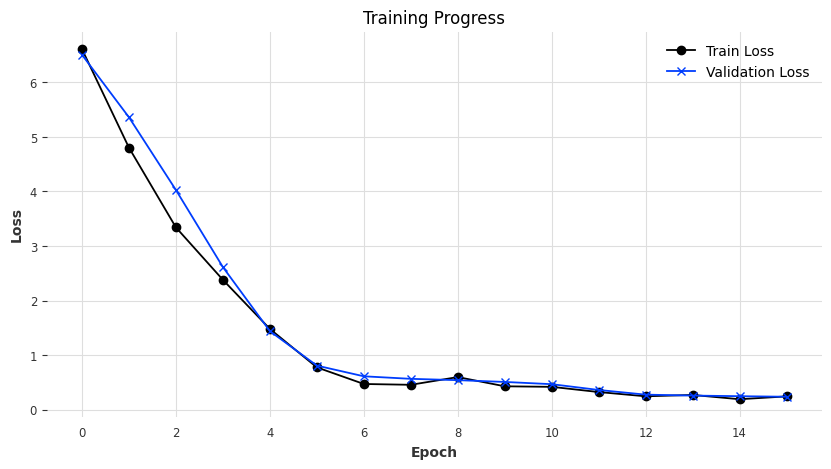

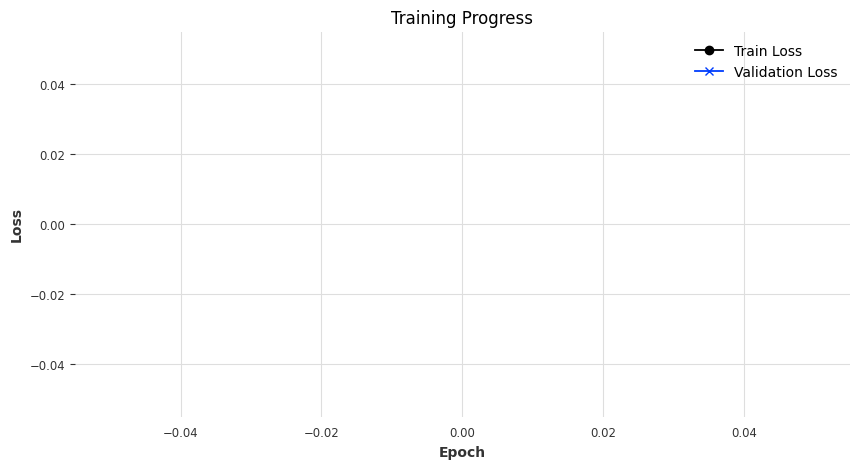

In [155]:

def load_model(model_path: str, architecture: str = 'TFT'): 
    """
    Load a Temporal Fusion Transformer (TFT) model from a file.
    
    :param model_path: 
        Path to the saved model file
    :return: 
        Loaded TFT model
    """
    
    if architecture == 'TFT':
        model = TFTModel.load(model_path, map_location=torch.device("cpu"),
                              pl_trainer_kwargs={"accelerator": "cpu",
                                                 "logger": False
                                                 }
                              )
 
    elif architecture == 'LSTM':
        model = RNNModel.load(model_path,map_location=torch.device("cpu"))

    return model

#======================
# --- Invers transform (log + scaler) --

def predict_with_loaded_model(station_id:str, model_path, oldDF = None, df = None, architecture = 'TFT', input_chunk_length=168, output_chunk_length=48, year:int = None):
    """
    Predict using a loaded Temporal Fusion Transformer (TFT) model.
    
    :param model: 
        Loaded TFT model
    :param df: 
        DataFrame containing the data
    :param station_id: 
        Station ID for naming
    :return: 
        Predicted TimeSeries
    """

    def inverse_all(ts, model = 'TFT'): return inverse_log_transform(ts)

    EICcodes = {
        'SE1': '10Y1001A1001A44P',
        'SE3': '10Y1001A1001A46L',}
    stations = {
        'SE1': SE1_stations,
        'SE3': SE3_stations,
    }

    model = load_model(model_path=model_path, architecture=architecture)
    while df is not None:
        
        df = df.copy()
        time_col = "timestamp"
        target_col = f'Vindkraft produktion {station_id} MWh'
        cyclic_col = ['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']
        # Scalers
        target_scaler = Scaler()
        covariate_scaler = Scaler()

        # Prepare series
        target = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=[target_col]).astype("float32")
        covariate_cols = [col for col in df.columns if col not in [time_col, target_col, 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']]

        cyclical_series = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=cyclic_col).astype("float32")
        covariates = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=covariate_cols).astype("float32")

        covariate_scaled = covariate_scaler.fit_transform(covariates)
        target_log = log_transform(target)
        covariate_scaled = covariate_scaled.stack(cyclical_series)
        break
    
    if oldDF == None and df == None:
        past_cov, future_cov, target, past_target_log , raw_past, raw_future = call_api(station_id, EICcodes, stations, current = False)
        horizon = 48
    

    if architecture == 'TFT':
        if oldDF is not None:
            oldDF = oldDF.copy()
            target = TimeSeries.from_dataframe(oldDF, time_col=time_col, value_cols=[target_col]).astype("float32")
            old_cov = TimeSeries.from_dataframe(oldDF, time_col=time_col, value_cols=covariate_cols).astype("float32")
            old_cyclical = TimeSeries.from_dataframe(oldDF, time_col=time_col, value_cols=cyclic_col).astype("float32")

            # Split the old data into past and future
            _, december_pow = target.split_before(pd.Timestamp("2024-12-25"))
            _, december = old_cov.split_before(pd.Timestamp("2024-12-25"))
            _, december_cyclical = old_cyclical.split_before(pd.Timestamp("2024-12-25"))
        """else:
            api = "https://api.opendata.esett.com/EXP16/Aggregate"
                   
            past_cov, future_cov, target = call_api(station_id, EICcodes)
                
                ### ========== SCALE DATA ===========


                ### TODO: Check code outside of block
                ### TODO: Try on both SE1 and SE3
                ### TODO: Adjust code for LSTM
                ### TODO: Make LSTM great again"""

        
        if year == 2025:
            val_pow_org = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=[target_col]).astype("float32")
            val_cyclical = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']).astype("float32")
            val_cov = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=covariate_cols).astype("float32")
            
            # stack before scaling
            val_cov = december.concatenate(val_cov)
            val_cyclical = december_cyclical.concatenate(val_cyclical)
            val_pow = december_pow.concatenate(val_pow_org)

            # scale the covariates
            val_cov = covariate_scaler.transform(val_cov)
            val_cov = val_cov.stack(val_cyclical)
            _, future_cov = val_cov.split_before(pd.Timestamp("2025-01-01"))

            val_pow_log = log_transform(val_pow)

            # finish off the covariates
            past_cov = val_cov.stack(val_pow_log)
            future_cov = val_cov


        ## ======== PREDICTION ========

        pred = model.predict(
        n=horizon,
        series=target,
        past_covariates=past_cov,
        future_covariates=future_cov,
        num_samples=100,  # Number of samples for quantile regression
        )


        pred1 = inverse_all(pred)
        lowest = inverse_all(pred.quantile_timeseries(0.01))
        low = inverse_all(pred.quantile_timeseries(0.05))
        pred_median = inverse_all(pred.quantile_timeseries(0.5))
        pred_p90 = inverse_all(pred.quantile_timeseries(0.95))

        return pred1, low, pred_median, pred_p90, target, lowest
    
    elif architecture == 'LSTM':
        #forecast_horizon = len(val_pow_log)-24*5
        forecast_horizon = horizon
        pred = model.predict(
        n=forecast_horizon,
        series=past_target_log,
        future_covariates=future_cov,
        )


        pred = inverse_log_transform(pred)
        return pred, None, None, None, target, None
    

station_ID = 'SE3'.upper()
architecture = 'tft'.upper()

path = {
    'SE3TFT': 'SE3modelFinal/gridsearch_tft_model_SE3-16 epochs.pth' ,
    'SE1TFT': 'S1_25\\tft_model_SE1_25_40_epochs.pth',
    'SE1LSTM': '21_25_LSTM_model_SE1-7_epochs.pth' ,
    'SE3LSTM':"21_25_LSTM_model_SE3-7_epochs.pth",
}
#model_path = 'SE3modelFinal/gridsearch_tft_model_SE3-16 epochs.pth' 
#model_path = 'S1_25\\tft_model_SE1_25_40_epochs.pth'
#model_path = '21_25_LSTM_model_SE1-7_epochs.pth' 
#model_path = "21_25_LSTM_model_SE1-20_epochs.pth"
#pred, pred_p05, pred_median, pred_p95, actual, powerScaler = predict_with_loaded_model(station_id='SE1', model_path = model_path, architecture='TFT')
pred, pred_p05, pred_median, pred_p95, actual, lowest = predict_with_loaded_model(station_id=station_ID, model_path = path[f'{station_ID}{architecture}'], architecture=architecture)
pred


In [156]:
SE3

,timestamp,Borlange Airport pres,Borlange Airport temp,Borlange Airport wpgt_x,Borlange Airport wpgt_y,Borlange Airport wspd_x,Borlange Airport wspd_y,Goteborg Landvetter Airport pres,Goteborg Landvetter Airport temp,Goteborg Landvetter Airport wpgt_x,Goteborg Landvetter Airport wpgt_y,Goteborg Landvetter Airport wspd_x,Goteborg Landvetter Airport wspd_y,Goteborg Save Airport pres,Goteborg Save Airport temp,Goteborg Save Airport wpgt_x,Goteborg Save Airport wpgt_y,Goteborg Save Airport wspd_x,Goteborg Save Airport wspd_y,Goteborg pres,Goteborg temp,Goteborg wpgt_x,Goteborg wpgt_y,Goteborg wspd_x,Goteborg wspd_y,Hagfors / Uddeholm pres,Hagfors / Uddeholm temp,Hagfors / Uddeholm wpgt_x,Hagfors / Uddeholm wpgt_y,Hagfors / Uddeholm wspd_x,Hagfors / Uddeholm wspd_y,Hagshult Airport pres,Hagshult Airport temp,Hagshult Airport wpgt_x,Hagshult Airport wpgt_y,Hagshult Airport wspd_x,Hagshult Airport wspd_y,Jonkoping Airport pres,Jonkoping Airport temp,Jonkoping Airport wpgt_x,Jonkoping Airport wpgt_y,Jonkoping Airport wspd_x,Jonkoping Airport wspd_y,Karlstad Airport pres,Karlstad Airport temp,Karlstad Airport wpgt_x,Karlstad Airport wpgt_y,Karlstad Airport wspd_x,Karlstad Airport wspd_y,Linkoping pres,Linkoping temp,Linkoping wpgt_x,Linkoping wpgt_y,Linkoping wspd_x,Linkoping wspd_y,Nolgård Airport pres,Nolgård Airport temp,Nolgård Airport wpgt_x,Nolgård Airport wpgt_y,Nolgård Airport wspd_x,Nolgård Airport wspd_y,Nordkoster pres,Nordkoster temp,Nordkoster wpgt_x,Nordkoster wpgt_y,Nordkoster wspd_x,Nordkoster wspd_y,Orebro / Tredingskullen pres,Orebro / Tredingskullen temp,Orebro / Tredingskullen wpgt_x,Orebro / Tredingskullen wpgt_y,Orebro / Tredingskullen wspd_x,Orebro / Tredingskullen wspd_y,Satenas Airport pres,Satenas Airport temp,Satenas Airport wpgt_x,Satenas Airport wpgt_y,Satenas Airport wspd_x,Satenas Airport wspd_y,Siljan / Vinäs pres,Siljan / Vinäs temp,Siljan / Vinäs wpgt_x,Siljan / Vinäs wpgt_y,Siljan / Vinäs wspd_x,Siljan / Vinäs wspd_y,Stockholm Arlanda Airport pres,Stockholm Arlanda Airport temp,Stockholm Arlanda Airport wpgt_x,Stockholm Arlanda Airport wpgt_y,Stockholm Arlanda Airport wspd_x,Stockholm Arlanda Airport wspd_y,Stockholm Skavsta / Blacksta pres,Stockholm Skavsta / Blacksta temp,Stockholm Skavsta / Blacksta wpgt_x,Stockholm Skavsta / Blacksta wpgt_y,Stockholm Skavsta / Blacksta wspd_x,Stockholm Skavsta / Blacksta wspd_y,Trollhattan / Höga pres,Trollhattan / Höga temp,Trollhattan / Höga wpgt_x,Trollhattan / Höga wpgt_y,Trollhattan / Höga wspd_x,Trollhattan / Höga wspd_y,Tullinge Eklundshov pres,Tullinge Eklundshov temp,Tullinge Eklundshov wpgt_x,Tullinge Eklundshov wpgt_y,Tullinge Eklundshov wspd_x,Tullinge Eklundshov wspd_y,Vasteras Hasslo Airport pres,Vasteras Hasslo Airport temp,Vasteras Hasslo Airport wpgt_x,Vasteras Hasslo Airport wpgt_y,Vasteras Hasslo Airport wspd_x,Vasteras Hasslo Airport wspd_y,Vindkraft produktion SE3 MWh,Visby Airport pres,Visby Airport temp,Visby Airport wpgt_x,Visby Airport wpgt_y,Visby Airport wspd_x,Visby Airport wspd_y,dayofweek_cos,dayofweek_sin,dayofyear_cos,dayofyear_sin,hour_cos,hour_sin
0,2021-01-02 00:00:00,1012.1,0.1,4.017396,2.319444,1.732051,1.000000,1010.1,-0.4,2.694444,0.000000e+00,1.111111,0.000000e+00,1010.2,-0.2,2.272546,2.806360,0.961462,1.187306,1010.2,0.7,1.111111,0.000000,0.000000,0.000000,1011.0,0.0,2.521617,-1.229875,1.448057,-0.706265,1009.4,0.2,2.079039,0.366591,0.984808,0.173648,1009.6,0.1,2.897386,1.054562e+00,0.939693,3.420201e-01,1011.1,0.3,4.359130,1.586593,1.827180,0.665039,1010.0,0.0,2.261289,1.305556,1.299038,0.750000,1011.1,0.3,4.333027e+00,1.577093,1.879385e+00,0.684040,1010.7,1.9,3.055556,5.292377,1.944444,3.367877,1010.0,1.0,3.127314,1.805556,2.261289,1.305556,1010.2,0.9,1.111111,0.000000,0.000000,0.000000,1012.0,0.0,2.954423,-0.520945,1.477212,-0.260472,1011.6,0.7,2.055556,3.560327,1.500000,2.598076,1010.0,1.0,0.475028,1.305129,0.893053,2.453642,1010.0,1.0,2.079039,-0.366591,0.984808,-0.173648,1011.4,0.7,-3.928147e+00,4.681383,-1.249865e+00

In [157]:
start = pd.Timestamp('2025-05-27')
end = start + timedelta(days=2)
three_days_ago = now - timedelta(days=8)
seven_days_ago = now - timedelta(days=11)
future = now - timedelta(days=1)
        
start = start.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
#three_days_ago = three_days_ago.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
end = end.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
#future = future.replace(hour=23, minute=0, second=0, microsecond=0).isoformat()

### ========== LOADING PRODUCTION DATA FROM ESATT ===========
MBA = EICcodes[station_ID]

cols = [
    "timestamp", "timestampUTC", "mba", "total",
    "wind", "windOffshore", "solar", "hydro",
    "thermal", "nuclear", "other", "energyStorage"
        ]
columns = ['timestamp', "timestampUTC", 'wind']

datorfrejm = fetch_esett_aggregate(
    mba_codes=[MBA],
    start= start + ".000Z",           # Time start
    end=  end + ".000Z",           # Time end
    resolution="hour",
    columns = columns,
)

target = TimeSeries.from_dataframe(datorfrejm, time_col='timestampUTC', value_cols = ['wind']).astype("float32")

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


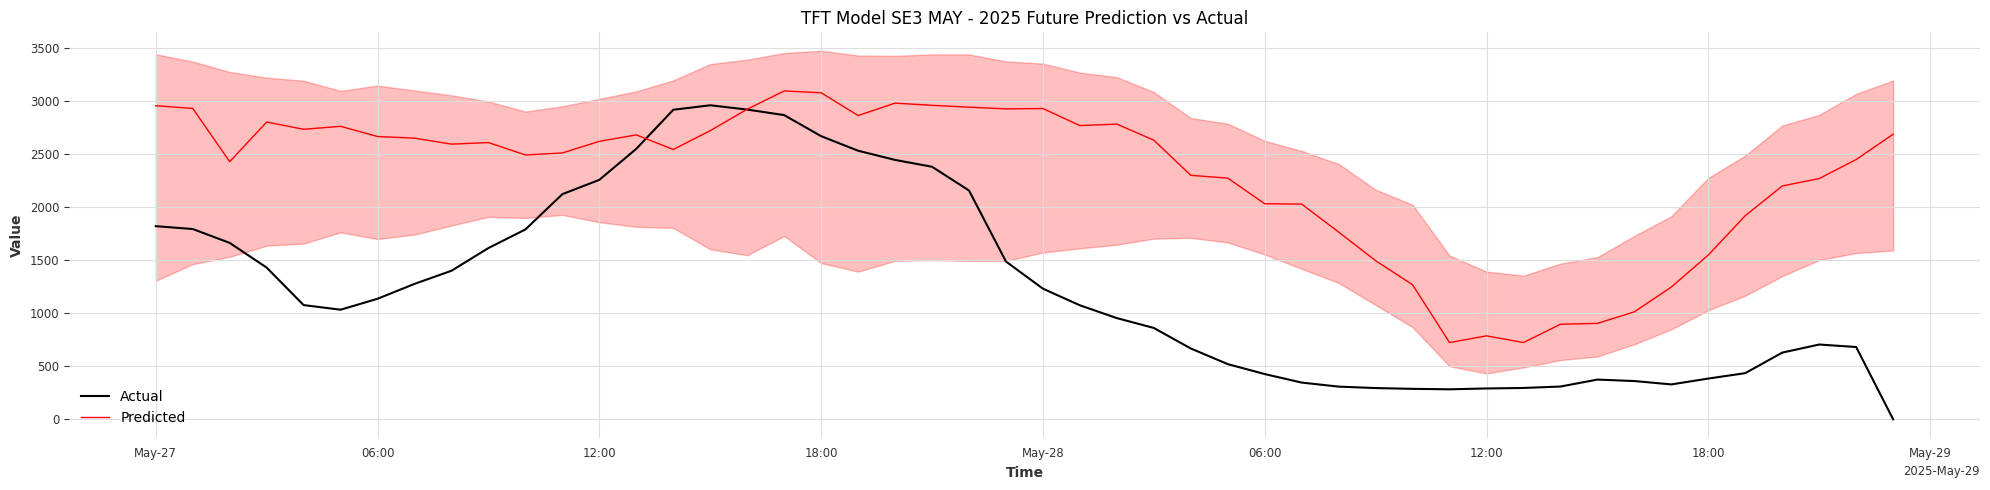

TFT Model SE3 MAY - 2025 Future Prediction vs Actual.png


<Figure size 640x480 with 0 Axes>

In [158]:
import matplotlib.pyplot as plt

def plot_prediction_vs_actual(pred, actual, title="Prediction vs Actual", figsize=(12, 5)):
    
    plt.figure(figsize=figsize)
    
    
    # Plot predicted values
    actual.plot(label="Actual", linewidth=1.5)
    pred.plot(label="Predicted", linewidth=1, color='red')
    # Plot actual values
    
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # save plot
    # assume title is already defined
    base_fname = f"{title}.png"
    save_fname = base_fname

    if os.path.exists(base_fname):
        # get current date in YYYY-MM-DD format
        date_str = datetime.now().strftime("%Y-%m-%d")
        save_fname = f"{title}_{date_str}.png"
    print(save_fname)
    plt.savefig('imgs\\'+save_fname, dpi=300, bbox_inches='tight')
    #_, actual = actual.split_before(pd.Timestamp('2025-02-25'))"""
plot_prediction_vs_actual(pred, target, title=f"{architecture} Model {station_ID} MAY - 2025 Future Prediction vs Actual", figsize=(20, 5))

In [159]:
station_id = 'SE3'.upper()


In [160]:
past_cov, future_cov, target, past_target_log , raw_past, raw_future = call_api(station_id, EICcodes, stations, current = False)

raw_future.to_csv(f'raw_future_{station_id}.csv', index=False)
raw_future

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


,timestamp,Stockholm Arlanda Airport wspd,Stockholm Arlanda Airport temp,Stockholm Arlanda Airport wpgt,Stockholm Arlanda Airport pres,Tullinge Eklundshov wspd,Tullinge Eklundshov temp,Tullinge Eklundshov wpgt,Tullinge Eklundshov pres,Stockholm Skavsta / Blacksta wspd,Stockholm Skavsta / Blacksta temp,Stockholm Skavsta / Blacksta wpgt,Stockholm Skavsta / Blacksta pres,Vasteras Hasslo Airport wspd,Vasteras Hasslo Airport temp,Vasteras Hasslo Airport wpgt,Vasteras Hasslo Airport pres,Borlange Airport wspd,Borlange Airport temp,Borlange Airport wpgt,Borlange Airport pres,Siljan / Vinäs wspd,Siljan / Vinäs temp,Siljan / Vinäs wpgt,Siljan / Vinäs pres,Orebro / Tredingskullen wspd,Orebro / Tredingskullen temp,Orebro / Tredingskullen wpgt,Orebro / Tredingskullen pres,Nolgård Airport wspd,Nolgård Airport temp,Nolgård Airport wpgt,Nolgård Airport pres,Karlstad Airport wspd,Karlstad Airport temp,Karlstad Airport wpgt,Karlstad Airport pres,Hagfors / Uddeholm wspd,Hagfors / Uddeholm temp,Hagfors / Uddeholm wpgt,Hagfors / Uddeholm pres,Linkoping wspd,Linkoping temp,Linkoping wpgt,Linkoping pres,Nordkoster wspd,Nordkoster temp,Nordkoster wpgt,Nordkoster pres,Goteborg Save Airport wspd,Goteborg Save Airport temp,Goteborg Save Airport wpgt,Goteborg Save Airport pres,Goteborg wspd,Goteborg temp,Goteborg wpgt,Goteborg pres,Satenas Airport wspd,Satenas Airport temp,Satenas Airport wpgt,Satenas Airport pres,Goteborg Landvetter Airport wspd,Goteborg Landvetter Airport temp,Goteborg Landvetter Airport wpgt,Goteborg Landvetter Airport pres,Trollhattan / Höga wspd,Trollhattan / Höga temp,Trollhattan / Höga wpgt,Trollhattan / Höga pres,Jonkoping Airport wspd,Jonkoping Airport temp,Jonkoping Airport wpgt,Jonkoping Airport pres,Hagshult Airport wspd,Hagshult Airport temp,Hagshult Airport wpgt,Hagshult Airport pres,Visby Airport wspd,Visby Airport temp,Visby Airport wpgt,Visby Airport pres,Stockholm Arlanda Airport wdir_sin,Stockholm Arlanda Airport wdir_cos,Tullinge Eklundshov wdir_sin,Tullinge Eklundshov wdir_cos,Stockholm Skavsta / Blacksta wdir_sin,Stockholm Skavsta / Blacksta wdir_cos,Vasteras Hasslo Airport wdir_sin,Vasteras Hasslo Airport wdir_cos,Borlange Airport wdir_sin,Borlange Airport wdir_cos,Siljan / Vinäs wdir_sin,Siljan / Vinäs wdir_cos,Orebro / Tredingskullen wdir_sin,Orebro / Tredingskullen wdir_cos,Nolgård Airport wdir_sin,Nolgård Airport wdir_cos,Karlstad Airport wdir_sin,Karlstad Airport wdir_cos,Hagfors / Uddeholm wdir_sin,Hagfors / Uddeholm wdir_cos,Linkoping wdir_sin,Linkoping wdir_cos,Nordkoster wdir_sin,Nordkoster wdir_cos,Goteborg Save Airport wdir_sin,Goteborg Save Airport wdir_cos,Goteborg wdir_sin,Goteborg wdir_cos,Satenas Airport wdir_sin,Satenas Airport wdir_cos,Goteborg Landvetter Airport wdir_sin,Goteborg Landvetter Airport wdir_cos,Trollhattan / Höga wdir_sin,Trollhattan / Höga wdir_cos,Jonkoping Airport wdir_sin,Jonkoping Airport wdir_cos,Hagshult Airport wdir_sin,Hagshult Airport wdir_cos,Visby Airport wdir_sin,Visby Airport wdir_cos
0,2025-05-27 00:00:00,3.083333,8.8,5.138889,1008.5,1.527778,7.3,3.611111,1009.9,2.305556,8.500000,4.888889,1010.700000,4.805556,10.100000,8.500000,1009.100000,3.611111,7.7,6.166667,1006.7,1.194444,7.000000,2.694444,1006.300000,3.194444,9.000000,9.611111,1009.600000,3.305556,9.200000,6.388889,1008.800000,4.111111,8.3,8.750000,1008.6,3.194444,9.900000,7.694444,1007.800000,2.805556,9.300000,5.694444,1011.000000,8.222222,10.4,12.361111,1008.0,6.694444,10.7,8.750000,1010.7,2.583333,11.1,6.166667,1010.9,5.138889,8.5,7.194444,1010.0,0.888889,9.000000,2.888889,1011.200000,3.500000,9.400000,6.305556,1010.500000,3.611111,7.6,5.138889,1011.7,1.194444,8.200000,3.305556,1012.100000,4.111111,9.6,6.166667,1012.1,-6.156615e-01,-0.788011,-0.798636,-0.601815,-0.906308,-0.422618,-0.788011,-0.615661,-5.299193e-01,-0.848048,-0.034899,-0.999391,-0.788011,-0.615661,-0.484810,-0.874620,-0.500000,-0.866025,-5.446390e-01,-0.838671,-6.018150e-01,-0.798636,-0.669131,-0.743145,-0.694658,-0.719340,-0.469472,-0.882948,

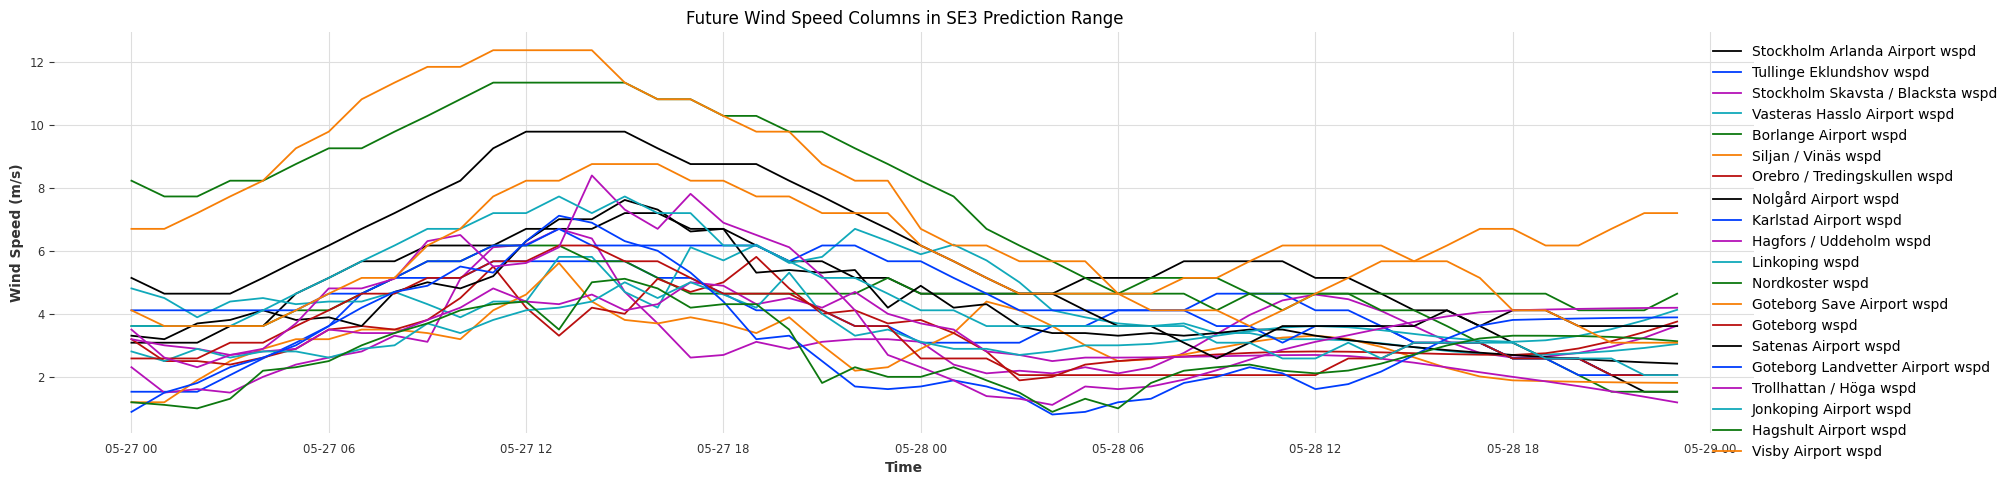

In [161]:
def plot_all_windspeed_columns(df, title="Future Wind Speed Columns", figsize=(20, 6)):
    """
    Plot all wind speed columns in a DataFrame with datetime x-axis.
    """
    plt.figure(figsize=figsize)
    wind_cols = [col for col in df.columns if 'wspd' in col]
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    df_plot = df.set_index('timestamp')
    for col in wind_cols:
        plt.plot(df_plot.index, df_plot[col], label=col)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Wind Speed (m/s)")
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot future windspeed for the prediction range
plot_all_windspeed_columns(raw_future, title=f"Future Wind Speed Columns in {station_ID} Prediction Range", figsize=(20, 5))


In [ ]:
raw_past

,timestamp,Stockholm Arlanda Airport wspd,Stockholm Arlanda Airport temp,Stockholm Arlanda Airport wdir,Stockholm Arlanda Airport wpgt,Stockholm Arlanda Airport pres,Tullinge Eklundshov wspd,Tullinge Eklundshov temp,Tullinge Eklundshov wdir,Tullinge Eklundshov wpgt,Tullinge Eklundshov pres,Stockholm Skavsta / Blacksta wspd,Stockholm Skavsta / Blacksta temp,Stockholm Skavsta / Blacksta wdir,Stockholm Skavsta / Blacksta wpgt,Stockholm Skavsta / Blacksta pres,Vasteras Hasslo Airport wspd,Vasteras Hasslo Airport temp,Vasteras Hasslo Airport wdir,Vasteras Hasslo Airport wpgt,Vasteras Hasslo Airport pres,Borlange Airport wspd,Borlange Airport temp,Borlange Airport wdir,Borlange Airport wpgt,Borlange Airport pres,Siljan / Vinäs wspd,Siljan / Vinäs temp,Siljan / Vinäs wdir,Siljan / Vinäs wpgt,Siljan / Vinäs pres,Orebro / Tredingskullen wspd,Orebro / Tredingskullen temp,Orebro / Tredingskullen wdir,Orebro / Tredingskullen wpgt,Orebro / Tredingskullen pres,Nolgård Airport wspd,Nolgård Airport temp,Nolgård Airport wdir,Nolgård Airport wpgt,Nolgård Airport pres,Karlstad Airport wspd,Karlstad Airport temp,Karlstad Airport wdir,Karlstad Airport wpgt,Karlstad Airport pres,Hagfors / Uddeholm wspd,Hagfors / Uddeholm temp,Hagfors / Uddeholm wdir,Hagfors / Uddeholm wpgt,Hagfors / Uddeholm pres,Linkoping wspd,Linkoping temp,Linkoping wdir,Linkoping wpgt,Linkoping pres,Nordkoster wspd,Nordkoster temp,Nordkoster wdir,Nordkoster wpgt,Nordkoster pres,Goteborg Save Airport wspd,Goteborg Save Airport temp,Goteborg Save Airport wdir,Goteborg Save Airport wpgt,Goteborg Save Airport pres,Goteborg wspd,Goteborg temp,Goteborg wdir,Goteborg wpgt,Goteborg pres,Satenas Airport wspd,Satenas Airport temp,Satenas Airport wdir,Satenas Airport wpgt,Satenas Airport pres,Goteborg Landvetter Airport wspd,Goteborg Landvetter Airport temp,Goteborg Landvetter Airport wdir,Goteborg Landvetter Airport wpgt,Goteborg Landvetter Airport pres,Trollhattan / Höga wspd,Trollhattan / Höga temp,Trollhattan / Höga wdir,Trollhattan / Höga wpgt,Trollhattan / Höga pres,Jonkoping Airport wspd,Jonkoping Airport temp,Jonkoping Airport wdir,Jonkoping Airport wpgt,Jonkoping Airport pres,Hagshult Airport wspd,Hagshult Airport temp,Hagshult Airport wdir,Hagshult Airport wpgt,Hagshult Airport pres,Visby Airport wspd,Visby Airport temp,Visby Airport wdir,Visby Airport wpgt,Visby Airport pres
0,2025-05-15 00:00:00,6.666667,5.0,350.0,9.250000,1010.0,4.166667,5.5,356.0,11.944444,1010.7,5.277778,5.0,340.0,12.111111,1011.0,6.111111,7.0,350.0,14.694444,1013.0,6.666667,6.0,350.0,11.833333,1016.0,7.777778,4.0,330.0,11.194444,1019.0,8.333333,8.0,350.0,11.611111,1015.0,7.777778,5.0,340.0,12.888889,1017.0,8.055556,5.6,350.0,13.888889,1018.0,6.111111,4.0,360.0,12.000000,1018.0,5.277778,7.0,340.0,11.305556,1013.0,9.444444,7.5,8.0,14.722222,1020.4,3.611111,7.0,10.0,10.805556,1017.0,4.444444,8.8,15.0,10.000000,1017.0,10.000000,7.6,360.0,13.888889,1017.7,8.333333,7.0,20.0,11.888889,1016.0,6.666667,6.0,360.0,11.000000,1018.0,6.944444,6.3,340.0,8.750000,1014.9,4.722222,6.0,350.0,12.194444,1013.0,6.944444,5.4,360.0,10.277778,1009.2
1,2025-05-15 01:00:00,9.722222,6.0,360.0,9.777778,1010.0,5.666667,5.2,340.0,9.777778,1010.6,6.111111,6.0,330.0,14.111111,1011.0,6.666667,7.0,340.0,14.805556,1013.0,5.555556,5.0,340.0,11.833333,1016.0,5.555556,4.0,320.0,11.000000,1019.0,7.777778,7.0,350.0,11.611111,1015.0,7.222222,5.0,350.0,12.500000,1018.0,6.694444,7.0,341.0,14.916667,1018.1,5.277778,4.0,350.0,11.305556,1018.0,6.666667,7.0,350.0,13.111111,1013.0,9.777778,8.0,9.0,15.416667,1020.2,3.611111,6.0,10.0,11.333333,1018.0,2.583333,8.6,358.0,7.194444,1017.5,8.888889,7.0,360.0,13.388889,1018.0,8.333333,6.0,10.0,11.500000,1017.0,6.666667,6.0,360.0,10.500000,1018.0,7.777778,6.0,350.0,9.777778,1014.0,4.166667,6.0,340.0,13.000000,1013.0,7.777778,5.0,360.0,11.333333,1008.0
2,2025-05-15 02:00:00,10.833333,6.0,10.0,10.805556,1010.0,6.166667,5.5,341.0,10.805556,1010.6,7.222222,7.0,340.0,14.111111,1010.0,8.888889,7.0,340.0,13.805556,1013.

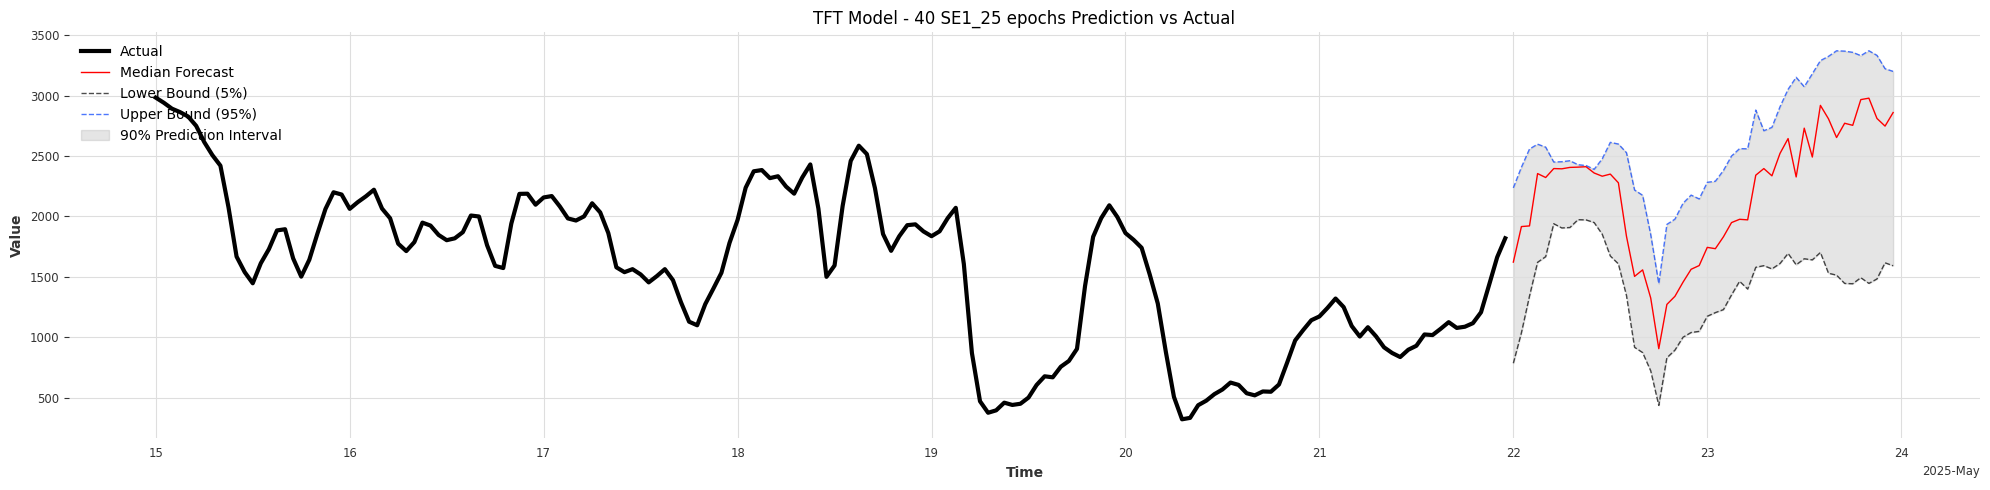

In [ ]:
def plot_prediction_vs_actual(
    lower: TimeSeries,
    upper: TimeSeries,
    median: TimeSeries,
    actual: TimeSeries,
    title: str = "Prediction vs Actual",
    figsize: tuple = (12, 5),
    save_path: str = None
) -> None:
    """
    Plots actual values, median forecast, and prediction intervals.

    Args:
        lower (TimeSeries): Lower‐quantile forecast (e.g. 5th percentile).
        upper (TimeSeries): Upper‐quantile forecast (e.g. 95th percentile).
        median (TimeSeries): Median forecast (50th percentile).
        actual (TimeSeries): Actual observed series.
        title (str): Chart title.
        figsize (tuple): Size of the figure.
        save_path (str, optional): Filepath to save the figure. If None, the plot is not saved.
    """
    plt.figure(figsize=figsize)
    ax = actual.plot(label="Actual", lw=3, color="black")
    median.plot(label="Median Forecast", lw=1, color="red", ax=ax)
    
    # Plot interval boundaries
    lower.plot(label="Lower Bound (5%)", linestyle="--", alpha=0.7, lw=1, ax=ax)
    upper.plot(label="Upper Bound (95%)", linestyle="--", alpha=0.7, lw=1, ax=ax)
    
    # Shade between them
    ax.fill_between(
        lower.time_index,
        lower.values().flatten(),
        upper.values().flatten(),
        color="gray",
        alpha=0.2,
        label="90% Prediction Interval"
    )
    
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend(loc="upper left")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    plt.show()
    
plot_prediction_vs_actual(pred_p05, pred_p95, pred_median, actual, title="TFT Model - 40 SE1_25 epochs Prediction vs Actual", figsize=(20, 5)
                          , save_path="tft_model_prediction_vs_actual_SE1_2025_MAY_13epochs.png")

In [ ]:
#pred_median.to_dataframe()
pred_p05 = pred_p05.stack(target)
pred_01 = lowest.stack(target)
pred_median = pred_median.stack(target)
pred_p95 = pred_p95.stack(target)

NameError: name 'target' is not defined

In [ ]:
#pred_median.to_dataframe()
pred = pred.stack(target)
#pred_p05.to_dataframe()
pred_df = pred.to_dataframe()

base_fname = f"{station_ID} {architecture} prediction.xlsx"
save_fname = base_fname

if os.path.exists(base_fname):
    # get current date in YYYY-MM-DD format
    date_str = datetime.now().strftime("%Y-%m-%d")
    save_fname = f"{station_ID} {architecture} prediction{date_str}.xlsx"
pred_df.to_excel(save_fname, index = True)
pred_df

In [ ]:
from sklearn.metrics import mean_absolute_error
def compute_mae(actual, predicted, as_sklearn: bool = True) -> float:
    """
    Compute the Mean Absolute Error between actual and predicted sequences.

    :param actual:    array‐like of shape (n,) or (n,1), or a Darts TimeSeries
    :param predicted: same type & shape as actual
    :param as_sklearn: if True, uses sklearn.metrics.mean_absolute_error;
                       otherwise uses pure numpy
    :return: float
    """
    # if they passed in Darts TimeSeries, extract values
    actual = actual.to_numpy()
    predicted = predicted.to_numpy()
    try:
        # .values() gives an (n,1) numpy array
        actual = actual.values().flatten()
        predicted = predicted.values().flatten()
    except AttributeError:
        # assume array‐like already
        actual = np.array(actual).flatten()
        predicted = np.array(predicted).flatten()

    if as_sklearn:
        return mean_absolute_error(actual, predicted)
    else:
        return float(np.mean(np.abs(actual - predicted)))
    
mae_value = compute_mae(pred_df["wind_1"], pred_df["wind"])
print("MAE:", mae_value)

In [ ]:
pred_p95.to_dataframe()

In [ ]:
# assume pred_df has columns "wind_1" (actual) and "wind" (predicted)
def stack_all(df, percentage):
    # 1) per‐hour absolute error
    wind = {
        '01': 'wind_0.01',
        '05': 'wind_0.05',
        '50': 'wind_0.5',
        '95': 'wind_0.95'
    }

    df['abs_error'] = (df['wind'] - df[wind[percentage]]).abs()

    # 2) optional: cumulative MAE up to each timestamp
    #    (i.e. mean absolute error of all hours from the start through this row)
    df['cum_mae'] = df['abs_error'].expanding().mean()
    return df

pred_01 = stack_all(pred_01.to_dataframe(), '01')
pred_p05 = stack_all(pred_p05.to_dataframe(), '05')
pred_median = stack_all(pred_median.to_dataframe(), '50')
pred_p95 = stack_all(pred_p95.to_dataframe(), '95')

In [ ]:
import numpy as np

# assume pred_df has columns "wind_1" (actual) and "wind" (predicted)

# 1) per‐hour absolute error
pred_df['abs_error'] = (pred_df['wind_1'] - pred_df['wind']).abs()

# 2) optional: cumulative MAE up to each timestamp
#    (i.e. mean absolute error of all hours from the start through this row)
pred_df['cum_mae'] = pred_df['abs_error'].expanding().mean()

pred_df


In [ ]:
import numpy as np

# 1) You already have abs_error; now % error per row:
pred_df['percent_error'] = (pred_df['abs_error'] 
                           / pred_df['wind_1'].replace(0, np.nan)  # avoid div-by-zero
                          ).abs() * 100

# 2) Optional: running (cumulative) MAPE up to each timestamp
pred_df['cum_MAPE'] = pred_df['percent_error'].expanding().mean()

# 3) Overall MAPE
overall_mape = pred_df['percent_error'].mean()
print(f"🏁 Overall MAPE: {overall_mape:.2f}%")

# 4) If you really want that same overall MAPE as a column on every row:
pred_df['overall_MAPE'] = overall_mape

# And if you only want it on the last row:
# last = pred_df.index[-1]
# pred_df.loc[last, 'overall_MAPE'] = overall_mape

# Inspect
print(pred_df.tail())
pred_df

In [ ]:
import numpy as np

def stack_again(df, percentage):
    wind = {
        '05': 'wind_0.05',
        '50': 'wind_0.5',
        '95': 'wind_0.95'
    }
    # 1) You already have abs_error; now % error per row:
    df['percent_error'] = (df['abs_error'] 
                            / df['wind'].replace(0, np.nan)  # avoid div-by-zero
                            ).abs() * 100

    # 2) Optional: running (cumulative) MAPE up to each timestamp
    df['cum_MAPE'] = df['percent_error'].expanding().mean()

    # 3) Overall MAPE
    overall_mape = df['percent_error'].mean()
    print(f"🏁 Overall MAPE: {overall_mape:.2f}%")

    # 4) If you really want that same overall MAPE as a column on every row:
    df['overall_MAPE'] = overall_mape

    # And if you only want it on the last row:
    # last = pred_df.index[-1]
    # pred_df.loc[last, 'overall_MAPE'] = overall_mape

    # Inspect
    #print(pred_df.tail())
    base_fname = f"{station_ID} {architecture} confidence {percentage} prediction_with_mae.xlsx"
    save_fname = base_fname
    if os.path.exists(base_fname):
        # get current date in YYYY-MM-DD format
        date_str = datetime.now().strftime("%Y-%m-%d")
        save_fname = f"{station_ID} {architecture} confidence {percentage} prediction{date_str}_with_mae.xlsx"
    pred_df.to_excel(save_fname, index = True)
    return df

full_pred = stack_again(pred_median, '50%')
full_pred

In [ ]:
base_fname = f"{station_ID} {architecture} prediction_with_mae.xlsx"
save_fname = base_fname
if os.path.exists(base_fname):
    # get current date in YYYY-MM-DD format
    date_str = datetime.now().strftime("%Y-%m-%d")
    save_fname = f"{station_ID} {architecture} prediction{date_str}_with_mae.xlsx"
pred_df.to_excel(save_fname, index = True)
pred_df

In [ ]:
stop

In [ ]:
def train_tft_model(df, station_id: str, validation_set = None, input_chunk_length=168, output_chunk_length=48, hidden_size=128, lstm_layers=2, num_attention_heads=4, dropout=0.2, batch_size=64, n_epochs=1, lr = 1e-4):
    """
    Train and evaluate a Temporal Fusion Transformer (TFT) on the specified wind station's data.
    """

    df, validation_set = call_api(station_id, EICcodes, stations, current = False, train = True)
    
    df = df.copy()
    time_col = "timestamp"
    target_col = f'Vindkraft produktion {station_id} MWh'

    # Prepare the target series
    power_values = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=[target_col]).astype("float32")
    cyclical_series = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']).astype("float32")

    # Drop target from covariates
    covariate_cols_past = [col for col in df.columns if col not in [time_col, target_col, 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']]
    covariate_cols_future = [col for col in df.columns if col not in [time_col, target_col, 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']]

    # Create covariate TimeSeries
    past_cov = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=covariate_cols_past).astype("float32")
    future_cov = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=covariate_cols_future).astype("float32")

    ### ============ IS NOT IN USE ============
    """if validation_set == None:
        power_train, _ = power_values.split_before(pd.Timestamp("2024-01-01"))
        _, power_test = power_values.split_before(pd.Timestamp("2023-12-25"))
        past_cov_train, _ = past_cov.split_before(pd.Timestamp("2024-01-01"))
        _, past_cov_test = past_cov.split_before(pd.Timestamp("2023-12-01"))
        future_cov_train, _ = future_cov.split_before(pd.Timestamp("2024-01-01"))
        _, future_cov_test = future_cov.split_before(pd.Timestamp("2023-12-25"))

        past_cyclical, _ = cyclical_series.split_before(pd.Timestamp("2024-01-01"))
        future_cov_cyclic, _ = cyclical_series.split_before(pd.Timestamp("2024-01-01"))
        _, past_test_cyclical = cyclical_series.split_before(pd.Timestamp("2023-12-01"))
        _, future_cyclical = cyclical_series.split_before(pd.Timestamp("2023-12-25"))"""

    ### ============ /ENDOF IS NOT IN USE ============

    ### ========= Normalize data =========
    target_scaler = Scaler()
    past_cov_scaler = Scaler()
    future_cov_scaler = Scaler()

    power_log = log_transform(power_values)
    #power_log_test = log_transform(power_test)


    # Scale the covariates
    past_cov_train_scaled = past_cov_scaler.fit_transform(past_cov)
    future_cov_train_scaled = future_cov_scaler.fit_transform(future_cov)

    #past_cov_test_scaled = past_cov_scaler.transform(past_cov_test)
    #future_cov_test_scaled = future_cov_scaler.transform(future_cov_test)

    if validation_set is not None:
        # Prepare the validation set
        val_power = TimeSeries.from_dataframe(validation_set, time_col=time_col, value_cols=[target_col]).astype("float32")
        val_covariates_past = TimeSeries.from_dataframe(validation_set, time_col=time_col, value_cols=covariate_cols_past).astype("float32")
        val_covariates_future = TimeSeries.from_dataframe(validation_set, time_col=time_col, value_cols=covariate_cols_future).astype("float32")
        val_cyclical_series = TimeSeries.from_dataframe(validation_set, time_col=time_col, value_cols=['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']).astype("float32")
        
        val_covariates_past_scaled = past_cov_scaler.transform(val_covariates_past)
        val_covariates_future_scaled = future_cov_scaler.transform(val_covariates_future)

        val_power_log = log_transform(val_power)
        val_covariates_past_scaled = val_covariates_past_scaled.stack(val_cyclical_series)
        val_covariates_past_scaled = val_covariates_past_scaled.stack(val_power_log)
        val_covariates_future_scaled = val_covariates_future_scaled.stack(val_cyclical_series)
        #return val_power_log, val_covariates_future_scaled, val_covariates_past_scaled


    past_cov_train_scaled = past_cov_train_scaled.stack(cyclical_series)
    past_cov_test_scaled = past_cov_train_scaled.copy()
    past_cov_train_scaled = past_cov_train_scaled.stack(power_log)
    #future_cov_train_scaled = future_cov_train_scaled.stack(Power_scaled)
    future_cov_train_scaled = future_cov_train_scaled.stack(cyclical_series)
    
    #return past_cov_train_scaled, None
    
    ### ========= CALLBACK DEFINE =============
    callbacks = [PersistentLivePlotCallback()]
    if validation_set is not None:
        # Early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=True,
            mode='min',
            min_delta=0.005,
        )
        callbacks.append(early_stopping)

    ### ======== DEFINE MODEL ==========
    model = TFTModel(
        input_chunk_length=input_chunk_length,      # Past 7 days
        output_chunk_length=output_chunk_length,    # Predict next 3 days
        hidden_size=hidden_size,                    # Hidden size of the LSTM layers
        lstm_layers=lstm_layers,                    # Number of LSTM layers
        num_attention_heads=num_attention_heads,    # Number of attention heads
        dropout=dropout,                            # Dropout rate
        batch_size=batch_size,
        n_epochs=n_epochs,
        #early_stopping=True,
        optimizer_kwargs={"lr": lr},
        random_state=42,
        save_checkpoints=True,
        work_dir='/checkpoints_tft_model',
        pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices": 1,
            "precision": "32-true",
            "callbacks": callbacks,
        },
        likelihood = QuantileRegression(quantiles=[0.05, 0.5, 0.95]), # Quantile loss for probabilistic forecasting
        #loss_fn=torch.nn.L1Loss(),      # Use L1 loss for robustness to outliers
        )


    ### ========== EURO - HUH - TRAINING ===========
    model.fit(
        series=power_log,
        past_covariates=past_cov_train_scaled,
        future_covariates=past_cov_test_scaled,
        val_series=val_power_log,
        val_past_covariates=val_covariates_past_scaled,
        val_future_covariates=val_covariates_future_scaled,
        verbose=True,
    )

    # Initial save name
    base_name = f"tft_model_{station_id}-{n_epochs} epochs"
    save_name = f"{base_name}.pth"
    number = 1

    while save_name in os.listdir():
        save_name = f"{base_name}_{number}.pth"
        number += 1

    # Save the model with the final unique name
    #model.save(save_name)
    model.save('gridsearch_'+save_name)

    # Predict
    # --- 7. Förklaringsbarhet med TFTExplainer ---
    explainer = TFTExplainer(
    model,
    background_series=power_log,
    background_past_covariates=past_cov_train_scaled,
    background_future_covariates=future_cov_train_scaled,
    )

    return model, explainer

model, explainer = train_tft_model(
    SE1, 
    'SE1',
    validation_set = SE1_25, 
    input_chunk_length=168,          # 168, 7 days - 144, 6 days - 120, 5 days - 96, 4 days - 72, 3 days - 48, 2 days - 24, 1 day
    output_chunk_length=48,          # 48 hours = 2 days
    hidden_size=20,                  # from 128 - Hidden size of the LSTM layers
    lstm_layers=2,                   # 2 Number of LSTM layers
    num_attention_heads=1,           # 4
    dropout=0.3,                     # 0.2 Dropout rate   
    batch_size=128,                  # 64 
    n_epochs=3, 
    lr = 1e-4,
    )

#model.to_dataframe()
#print(model.name)
#pred.plot(label='Predicted', lw=2)


In [ ]:
def train_lstm_model(df, valdf = None, model='LSTM', station_id: str = 'SE1', year = 2024):
    """
    Train and evaluate an LSTM model on the specified wind station's data.
    """
    import pandas as pd
    from darts.models import RNNModel
    from darts import TimeSeries
    from darts.dataprocessing.transformers import Scaler
    
    ### Configuration for LSTM model
    training_length = 72
    input_chunk_length = 72
    output_chunk_length = 48
    n_epochs = 20
    
    
    df = df.copy()
    time_col = "timestamp"
    target_col = f'Vindkraft produktion {station_id} MWh'
    #cyclic_col = 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos'
    # Scalers
    target_scaler = Scaler()
    covariate_scaler = Scaler()

    # Prepare series
    target = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=[target_col]).astype("float32")
    covariate_cols = [col for col in df.columns if col not in [time_col, target_col, 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']]

    cyclical_series = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']).astype("float32")
    covariates = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=covariate_cols).astype("float32")

    covariate_scaled = covariate_scaler.fit_transform(covariates)
    target_log = log_transform(target)
    covariate_scaled = covariate_scaled.stack(cyclical_series)

    #return covariate_scaled, None
    #target_scaled = target_scaler.fit_transform(target)
    if year == 2024:

        split_point = pd.Timestamp("2024-01-01")
        
        # Build train/test/val sets
        train_target, val_target = target.split_before(split_point)
        _, train_target = train_target.split_before(pd.Timestamp("2022-01-01"))
        train_cov, val_cov = covariate_scaled.split_before(split_point)
        _, train_cov = covariate_scaled.split_before(pd.Timestamp("2022-01-01"))
        
        val_pow_log = log_transform(val_target)
        # Extend validation covariates backward to include training_length hours
        val_cov = covariate_scaled.drop_before(split_point - pd.Timedelta(hours=training_length+1))

    
    if year == 2025:
        val_pow = TimeSeries.from_dataframe(valdf, time_col=time_col, value_cols=[target_col]).astype("float32")
        val_cyclical = TimeSeries.from_dataframe(valdf, time_col=time_col, value_cols=['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos']).astype("float32")
        val_cov = TimeSeries.from_dataframe(valdf, time_col=time_col, value_cols=covariate_cols).astype("float32")
        val_cov = covariate_scaler.transform(val_cov)
        val_cov = val_cov.stack(val_cyclical)
        val_pow_log = log_transform(val_pow)

        _ , pred_val_1 = covariate_scaled.split_before(pd.Timestamp(2024-12-28))
        pred_val = pred_val_1.concatenate(val_cov)

    callbacks = [PersistentLivePlotCallback()]
    if valdf is not None:
        # Early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=True,
            mode='min',
            min_delta=0.005,
        )
        #callbacks.append(early_stopping)
    # Define model
    model = RNNModel(
        model=model,
        input_chunk_length=input_chunk_length,
        training_length=training_length,
        output_chunk_length=output_chunk_length,
        hidden_dim=420,
        n_rnn_layers=1,
        dropout=0.5,
        batch_size=256,
        n_epochs=n_epochs,
        nr_epochs_val_period=1,
        optimizer_kwargs={"lr": 1e-3},
        random_state=42,
        pl_trainer_kwargs={"accelerator": "gpu",
                            "devices": 1,
                            "callbacks": callbacks,
                            },
        loss_fn=torch.nn.L1Loss(),
    )

    # Train model
    model.fit(
        series=target_log,
        future_covariates=covariate_scaled,
        val_series=val_pow_log,
        val_future_covariates=val_cov,
        verbose=True
    )


    # Initial save name
    base_name = f"LSTM_model_{station_id}-{n_epochs}_epochs"
    save_name = f"{base_name}.pth"
    number = 1

    while save_name in os.listdir():
        save_name = f"{base_name}_{number}.pth"
        number += 1

    # Save the model with the final unique name
    #model.save(save_name)
    model.save('21_25_'+save_name)

    # Predict on validation set
    forecast_horizon = len(val_pow_log)
    pred_scaled = model.predict(
        n=forecast_horizon,
        series=val_pow_log,
        future_covariates=pred_val,
    )

    # Inverse transform
    prediction = inverse_log_transform(pred_scaled)
    #prediction = target_scaler.inverse_transform(pred_scaled)

    # For plotting actuals
    test_actual = target.drop_before(split_point)#.to_dataframe()
    #prediction = prediction.pd_dataframe()

    return prediction, test_actual



# Example usage
pred, test = train_lstm_model(SE1, SE1_25, model = 'LSTM', station_id= 'SE1', year = 2025)

#pred.to_dataframe()



In [ ]:
explanation = explainer.explain()
explainer.plot_attention(explanation, plot_type="all")
explainer.plot_variable_selection(explanation, fig_size=(20, 30))

In [17]:
import folium
import pandas as pd
import pytz
import warnings
from smhi.metobs import Parameters, Stations, Periods, Data
from IPython.display import display
from geopy.distance import geodesic

warnings.filterwarnings("ignore")

# --- Inställningar ---
start_date = pd.to_datetime("2021-02-27").tz_localize(pytz.UTC)
end_date = pd.to_datetime("2021-05-28").tz_localize(pytz.UTC)

"""
wanted_params = [
"Vindhastighet", "Vindriktning", "Byvind",
"Lufttemperatur", "Lufttryck reducerat havsytans nivå",
"Relativ Luftfuktighet", "Daggpunktstemperatur",
"Max av MedelVindhastighet"
]
"""



wanted_params = [
"Vindhastighet", "Vindriktning", "Byvind",
"Lufttemperatur", "Lufttryck reducerat havsytans nivå",
]

region_bounds = {
    "SE1": ((64.25, 69.5), (13.0, 24.0)),     # Norrbotten + delar av Västerbotten
    "SE2": ((60.0, 64.25), (12.0, 20.0)),     # Gävle → Sundsvall → Umeå
    "SE3": ((57.4, 60.0), (11.0, 19.5)),      # Stockholm, Västerås, Göteborg
    "SE4": ((54.5, 57.4), (11.0, 17.5)),      # Skåne, Blekinge, Öland, Gotland
}


colors = {"SE1": "red", "SE2": "green", "SE3": "blue", "SE4": "purple"}

def load_vindparker(filepath="Vindparker.xlsx"):
    df = pd.read_excel(filepath)
    df = df.dropna(subset=["lat", "lon"])
    df["SE_zone"] = df.apply(lambda row: find_se_zone(row["lat"], row["lon"]), axis=1)
    return df

def find_se_zone(lat, lon):
    for zone, ((lat_min, lat_max), (lon_min, lon_max)) in region_bounds.items():
        if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
            return zone
    return "Unknown"

def get_valid_stations():
    parameters = Parameters()
    station_param_sets = []

    for title in wanted_params:
        param = next(p for p in parameters.data if p.title == title and "1 gång/tim" in p.summary)
        stations = Stations(parameters, param.key)
        valid_stations = set()
        for s in stations.station:
            if not getattr(s, "active", True):
                continue
            try:
                lat, lon = float(s.latitude), float(s.longitude)
                valid_stations.add((s.name, lat, lon))
            except:
                continue
        station_param_sets.append(valid_stations)

    return set.intersection(*station_param_sets)

def filter_stations_with_forecast(valid_stations):
    parameters = Parameters()
    final_stations = []
    for name, lat, lon in valid_stations:
        all_ok = True
        for title in wanted_params:
            param = next(p for p in parameters.data if p.title == title and "1 gång/tim" in p.summary)
            stations = Stations(parameters, param.key)
            try:
                periods = Periods(stations, station_name=name)
                available = [p[0] for p in periods.data]
                if not set(available) & {'c', 'l'}:
                    all_ok = False
                    break
            except:
                all_ok = False
                break
        if all_ok:
            final_stations.append((name, lat, lon))
    return final_stations

def match_stations_to_vindparker(stations, vindparker_df, requested_zone):
    matched_stations = []
    vindparker_zone = vindparker_df[vindparker_df["SE_zone"] == requested_zone]
    for name, s_lat, s_lon in stations:
        for _, park in vindparker_zone.iterrows():
            dist = geodesic((s_lat, s_lon), (park["lat"], park["lon"])).km
            if dist <= 30:
                matched_stations.append({"name": name, "lat": s_lat, "lon": s_lon})
                break
    return matched_stations

def plot_folium_map(vindparker_df, zone_stations, requested_zone):
    m = folium.Map(location=[62, 15], zoom_start=5)

    # Vindparker (färgade per zon)
    for _, row in vindparker_df.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=5,
            popup=f"{row['Projekteringsområde']} ({row['antal_turbiner']} turbiner)",
            color=colors.get(row["SE_zone"], "gray"),
            fill=True,
            fill_opacity=0.7
        ).add_to(m)

    # Stationer (endast för requested_zone)
    for s in zone_stations:
        folium.Marker(
            [s["lat"], s["lon"]],
            popup=f"{requested_zone}: {s['name']}",
            icon=folium.Icon(color=colors[requested_zone])
        ).add_to(m)

    display(m)

def fetch_weather_data(station_list, requested_zone):
    all_data = []
    parameters = Parameters()

    for param in parameters.data:
        if param.title not in wanted_params or "1 gång/tim" not in param.summary:
            continue

        param_id = param.key
        stations = Stations(parameters, param_id)
        station_names = [s[1] for s in stations.data]

        for s in station_list:
            name = s["name"]
            if name not in station_names:
                continue
            try:
                periods = Periods(stations, station_name=name)
                available = [p[0] for p in periods.data]
                periods.selected = 'c' if 'c' in available else 'l' if 'l' in available else None
                if not periods.selected:
                    continue

                data = Data(periods)
                df = data.df
                if df.empty:
                    continue

                df["parameter_title"] = f"{name} - {param.title}"
                if "Datum" in df.columns and "Tid (UTC)" in df.columns:
                    df["timestamp"] = pd.to_datetime(df["Datum"] + " " + df["Tid (UTC)"], errors="coerce").dt.tz_localize("UTC")
                elif isinstance(df.index, pd.DatetimeIndex):
                    df["timestamp"] = df.index.tz_convert("UTC") if df.index.tz else df.index.tz_localize("UTC")
                else:
                    df["timestamp"] = pd.NaT

                value_col = next((col for col in wanted_params if col in df.columns), None)
                df["value"] = df[value_col] if value_col else pd.NA
                df["zone"] = requested_zone

                all_data.append(df[["timestamp", "parameter_title", "value", "zone"]])
            except:
                continue

    if all_data:
        combined_df = pd.concat(all_data).dropna(subset=["timestamp"]).sort_values("timestamp")
        pivoted = combined_df.pivot_table(
            index="timestamp",
            columns="parameter_title",
            values="value",
            aggfunc="first"
        ).reset_index()

        pivoted = pivoted[
            (pivoted["timestamp"] >= start_date) &
            (pivoted["timestamp"] <= end_date)
        ]
        return pivoted
    else:
        return pd.DataFrame()

# --- Huvudfunktion ---
def get_zone_dataframe(requested_zone):
    vindparker_df = load_vindparker()
    valid_stations = get_valid_stations()
    final_stations = filter_stations_with_forecast(valid_stations)
    zone_stations = match_stations_to_vindparker(final_stations, vindparker_df, requested_zone)
    plot_folium_map(vindparker_df, zone_stations, requested_zone)
    df_zone = fetch_weather_data(zone_stations, requested_zone)
    return df_zone


In [ ]:
df_se3 = get_zone_dataframe("SE1")
display(df_se3)


parameter_title,timestamp,Arjeplog A - Byvind,Arjeplog A - Lufttemperatur,Arjeplog A - Lufttryck reducerat havsytans nivå,Arjeplog A - Vindhastighet,Arjeplog A - Vindriktning,Bjuröklubb A - Byvind,Bjuröklubb A - Lufttemperatur,Bjuröklubb A - Lufttryck reducerat havsytans nivå,Bjuröklubb A - Vindhastighet,...,Storön A - Byvind,Storön A - Lufttemperatur,Storön A - Lufttryck reducerat havsytans nivå,Storön A - Vindhastighet,Storön A - Vindriktning,Vilhelmina A - Byvind,Vilhelmina A - Lufttemperatur,Vilhelmina A - Lufttryck reducerat havsytans nivå,Vilhelmina A - Vindhastighet,Vilhelmina A - Vindriktning
582780,2021-02-27 00:00:00+00:00,8.2,-1.6,1020.5,0.7,249.0,11.6,-1.2,1017.3,9.5,...,8.4,-3.4,NaN,5.5,301.0,3.5,-6.6,1022.9,0.0,0.0
582781,2021-02-27 01:00:00+00:00,5.8,-2.4,1020.7,1.6,313.0,12.3,-0.9,1018.1,9.2,...,6.9,-4.5,NaN,4.7,296.0,2.0,-6.8,1023.5,1.1,220.0
582782,2021-02-27 02:00:00+00:00,5.4,-2.2,1021.0,2.6,258.0,11.5,-1.1,1018.7,9.9,...,4.8,-6.7,NaN,3.2,299.0,3.9,-6.1,1023.5,1.1,291.0
582783,2021-02-27 03:00:00+00:00,6.8,-1.3,1020.7,1.8,270.0,11.3,-1.6,1019.3,9.3,...,5.4,-6.3,NaN,4.4,297.0,5.1,-1.7,1023.0,3.6,289.0
582784,2021-02-27 04:00:00+00:00,4.0,-1.5,1020.5,0.8,219.0,10.9,-1.9,1019.7,8.4,...,7.7,-2.6,NaN,6.1,303.0,3.2,-5.2,1023.2,1.1,246.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584936,2021-05-27 20:00:00+00:00,7.8,8.0,1013.3,2.9,280.0,6.3,4.2,1013.9,4.6,...,8.8,5.6,NaN,3.8,225.0,5.0,11.1,1013.7,2.5,313.0
584937,2021-05-27 21:00:00+00:00,7.0,6.9,1013.5,3.7,311.0,6.1,3.9,1013.3,4.3,...,6.4,5.7,NaN,4.7,230.0,4.3,7.2,1014.3,0.6,283.0
584938,2021-05-27 22:00:00+00:00,9.4,5.8,1013.8,1.4,360.0,5.8,3.9,1012.7,2.9,...,9.9,6.2,NaN,7.7,225.0,2.1,4.3,1014.9,1.1,288.0
584939,2021-05-27 23:00:00+00:00,6.3,5.0,1014.3,1.0,7.0,9.1,6.1,1011.9,6.2,...,8.9,6.4,NaN,5.1,260.0,1.9,2.5,1015.1,0.6,265.0


In [115]:
from smhi.metfcts import Metfcts

""" 
Kolumnförklaring för SMHI Metfcts punktdata

# name         : Ej relevant – används internt i datastrukturen
# Wsymb2       : Väderikonkod (symbolnummer enligt SMHI:s vädersymboler)
# gust         : Byvind (m/s)
# hcc_mean     : Medelhög molntäcke (0–8 oktas)
# lcc_mean     : Låg molntäcke (0–8 oktas)
# mcc_mean     : Mellan molntäcke (0–8 oktas)
# msl          : Lufttryck reducerat till havsnivå (hPa)
# pcat         : Nederbördskategori (0 = ingen, 1 = regn, 2 = snö, etc.)
# pmax         : Max nederbörd (mm)
# pmean        : Medel nederbörd (mm)
# pmedian      : Median nederbörd (mm)
# pmin         : Min nederbörd (mm)
# r            : Relativ luftfuktighet (%)
# spp          : Ospecificerad (kan vara placeholder, ofta -9 = saknas)
# t            : Lufttemperatur (°C)
# tcc_mean     : Totalt molntäcke (0–8 oktas)
# tp           : Nederbörd senaste timmen (mm)
# tstm         : Åsksannolikhet (0–100 %)
# vis          : Sikt (km)
# wd           : Vindriktning (grader från norr)
# ws           : Vindhastighet (m/s)
"""
# Initiera klient
client = Metfcts()
lat = 63.0
lon = 18.0
columns = ["ws", "gust", "wd", "t", "msl"]

point = client.get_point(lat, lon)  # SE1 nära

df = point.df[columns].reset_index().rename(columns={
	"valid_time": "timestamp",
	"ws": "Vindhastighet",
	"gust": "Byvind",
	"wd": "Vindriktning",
	"t": "Lufttemperatur",
	"msl": "Lufttryck"
})
df


name,timestamp,Vindhastighet,Byvind,Vindriktning,Lufttemperatur,Lufttryck
0,2025-06-02 20:00:00+00:00,3.3,7.0,293,11.7,1000.9
1,2025-06-02 21:00:00+00:00,4.4,9.5,299,10.4,1001.8
2,2025-06-02 22:00:00+00:00,5.1,10.9,303,9.6,1002.4
3,2025-06-02 23:00:00+00:00,5.2,11.5,309,9.1,1003.0
4,2025-06-03 00:00:00+00:00,4.7,11.2,307,8.6,1003.9
...,...,...,...,...,...,...
74,2025-06-10 12:00:00+00:00,3.8,9.8,227,14.2,1009.6
75,2025-06-11 00:00:00+00:00,2.9,6.8,231,8.3,1010.0
76,2025-06-11 12:00:00+00:00,3.7,9.8,229,14.7,1012.0
77,2025-06-12 00:00:00+00:00,2.4,6.5,212,9.3,1014.5


In [14]:
# -*- coding: utf-8 -*-
import pandas as pd
import pytz
import warnings
import json
from smhi.metobs import Parameters, Stations, Periods, Data
from smhi.metfcts import Metfcts
from geopy.distance import geodesic
from folium import Map, CircleMarker, Marker, Icon, Rectangle, Popup
from folium.features import DivIcon
from IPython.display import display

warnings.filterwarnings("ignore")

# --- Inställningar ---
start_date = pd.to_datetime("2021-02-27").tz_localize(pytz.UTC)
end_date = pd.to_datetime("2021-05-28").tz_localize(pytz.UTC)

wanted_params = [
    "Vindhastighet", "Vindriktning", "Byvind",
    "Lufttemperatur", "Lufttryck reducerat havsytans nivå"
]

param_translation = {
    "ws": "Vindhastighet",
    "wd": "Vindriktning",
    "gust": "Byvind",
    "t": "Lufttemperatur",
    "msl": "Lufttryck reducerat havsytans nivå"
}

region_bounds = {
    "SE1": ((64.25, 69.5), (13.0, 24.0)),
    "SE2": ((60.0, 64.25), (12.0, 20.0)),
    "SE3": ((57.4, 60.0), (11.0, 19.5)),
    "SE4": ((54.5, 57.4), (11.0, 17.5)),
}

colors = {"SE1": "red", "SE2": "green", "SE3": "blue", "SE4": "purple"}

# ------------------ Data Loading ------------------ #
def load_vindparker(filepath="Vindparker.xlsx"):
    df = pd.read_excel(filepath)
    df = df.dropna(subset=["lat", "lon"])
    df["SE_zone"] = df.apply(lambda row: find_se_zone(row["lat"], row["lon"]), axis=1)
    return df

def find_se_zone(lat, lon):
    for zone, ((lat_min, lat_max), (lon_min, lon_max)) in region_bounds.items():
        if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
            return zone
    return "Unknown"

# ------------------ Station Matching ------------------ #
def get_valid_stations():
    parameters = Parameters()
    station_param_sets = []
    for title in wanted_params:
        param = next(p for p in parameters.data if p.title == title and "1 gång/tim" in p.summary)
        stations = Stations(parameters, param.key)
        valid_stations = {
            (s.name, float(s.latitude), float(s.longitude))
            for s in stations.station if getattr(s, "active", True)
        }
        station_param_sets.append(valid_stations)
    return set.intersection(*station_param_sets)

def filter_stations_with_forecast(valid_stations):
    parameters = Parameters()
    final_stations = []
    for name, lat, lon in valid_stations:
        all_ok = True
        for title in wanted_params:
            param = next(p for p in parameters.data if p.title == title and "1 gång/tim" in p.summary)
            stations = Stations(parameters, param.key)
            try:
                periods = Periods(stations, station_name=name)
                available = [p[0] for p in periods.data]
                if not set(available) & {'c', 'l'}:
                    all_ok = False
                    break
            except:
                all_ok = False
                break
        if all_ok:
            final_stations.append((name, lat, lon))
    return final_stations

def match_stations_to_vindparker(stations, vindparker_df, requested_zone):
    matched_stations = []
    vindparker_zone = vindparker_df[vindparker_df["SE_zone"] == requested_zone]
    for name, s_lat, s_lon in stations:
        for _, park in vindparker_zone.iterrows():
            dist = geodesic((s_lat, s_lon), (park["lat"], park["lon"])).km
            if dist <= 30:
                matched_stations.append({"name": name, "lat": s_lat, "lon": s_lon})
                break
    return matched_stations

# ------------------ Save & Load ------------------ #
def save_zone_station_coordinates(zone, vindparker_df, final_stations):
    matched = match_stations_to_vindparker(final_stations, vindparker_df, zone)
    filename = f"station_coordinates_{zone}.json"
    with open(filename, "w") as f:
        json.dump(matched, f)

def load_station_coordinates(zone):
    filename = f"station_coordinates_{zone}.json"
    try:
        with open(filename, "r") as f:
            return json.load(f)
    except:
        return []

# ------------------ Visualisering ------------------ #
def plot_folium_map(vindparker_df, zone_stations, requested_zone):
    m = Map(location=[62, 15], zoom_start=5)

    for _, row in vindparker_df.iterrows():
        CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=5,
            popup=f"{row['Projekteringsområde']} ({row['antal_turbiner']} turbiner)",
            color=colors.get(row["SE_zone"], "gray"),
            fill=True,
            fill_opacity=0.7
        ).add_to(m)

    for s in zone_stations:
        Marker(
            [s["lat"], s["lon"]],
            popup=f"{requested_zone}: {s['name']}",
            icon=Icon(color=colors.get(requested_zone, "gray"))
        ).add_to(m)

    if requested_zone in region_bounds:
        (lat_min, lat_max), (lon_min, lon_max) = region_bounds[requested_zone]
        bounds = [[lat_min, lon_min], [lat_max, lon_max]]
        Rectangle(
            bounds=bounds,
            color=colors.get(requested_zone, "gray"),
            fill=True,
            fill_opacity=0.1,
            popup=Popup(f"{requested_zone} bounds")
        ).add_to(m)

        center_lat = (lat_min + lat_max) / 2
        center_lon = (lon_min + lon_max) / 2
        Marker(
            [center_lat, center_lon],
            icon=DivIcon(
                icon_size=(150, 36),
                icon_anchor=(0, 0),
                html=f'<div style="font-size: 14pt; color: {colors[requested_zone]};"><b>{requested_zone}</b></div>',
            )
        ).add_to(m)

    display(m)

# ------------------ Datainsamling ------------------ #
def fetch_forecast_data(requested_zone):
    client = Metfcts()
    station_list = load_station_coordinates(requested_zone)
    forecast_data = []
    for station in station_list:
        lat, lon, name = station["lat"], station["lon"], station["name"]
        point = client.get_point(lat, lon)
        df = point.df
        for short, title in param_translation.items():
            if short in df.columns:
                temp = df[[short]].copy()
                temp = temp.rename(columns={short: f"{name} - {title}"})
                temp["timestamp"] = df.index
                forecast_data.append(temp.set_index("timestamp"))
    if forecast_data:
        merged = pd.concat(forecast_data, axis=1).reset_index()
        return merged
    return pd.DataFrame()

def fetch_weather_data(station_list, requested_zone):
    all_data = []
    parameters = Parameters()
    for param in parameters.data:
        if param.title not in wanted_params or "1 gång/tim" not in param.summary:
            continue
        param_id = param.key
        stations = Stations(parameters, param_id)
        station_names = [s.name for s in stations.station]
        for s in station_list:
            name = s["name"]
            if name not in station_names:
                continue
            try:
                periods = Periods(stations, station_name=name)
                available = [p[0] for p in periods.data]
                periods.selected = 'c' if 'c' in available else 'l' if 'l' in available else None
                if not periods.selected:
                    continue
                data = Data(periods)
                df = data.df
                if df.empty:
                    continue
                df["parameter_title"] = f"{name} - {param.title}"
                if "Datum" in df.columns and "Tid (UTC)" in df.columns:
                    df["timestamp"] = pd.to_datetime(df["Datum"] + " " + df["Tid (UTC)"], errors="coerce").dt.tz_localize("UTC")
                elif isinstance(df.index, pd.DatetimeIndex):
                    df["timestamp"] = df.index.tz_convert("UTC") if df.index.tz else df.index.tz_localize("UTC")
                else:
                    df["timestamp"] = pd.NaT
                value_col = next((col for col in wanted_params if col in df.columns), None)
                df["value"] = df[value_col] if value_col else pd.NA
                df["zone"] = requested_zone
                all_data.append(df[["timestamp", "parameter_title", "value", "zone"]])
            except:
                continue
    if all_data:
        combined_df = pd.concat(all_data).dropna(subset=["timestamp"]).sort_values("timestamp")
        pivoted = combined_df.pivot_table(
            index="timestamp",
            columns="parameter_title",
            values="value",
            aggfunc="first"
        ).reset_index()
        pivoted = pivoted[(pivoted["timestamp"] >= start_date) & (pivoted["timestamp"] <= end_date)]
        return pivoted
    return pd.DataFrame()

# ------------------ Extern Användarfunktion ------------------ #
def get_zone_dataframe(requested_zone="SE1", forecast=False):
    vindparker_df = load_vindparker()
    valid_stations = get_valid_stations()
    final_stations = filter_stations_with_forecast(valid_stations)

    if not forecast:
        save_zone_station_coordinates(requested_zone, vindparker_df, final_stations)

    zone_stations = load_station_coordinates(requested_zone) if forecast else match_stations_to_vindparker(final_stations, vindparker_df, requested_zone)

    plot_folium_map(vindparker_df, zone_stations, requested_zone)

    if forecast:
        return fetch_forecast_data(requested_zone)
    else:
        return fetch_weather_data(zone_stations, requested_zone)


In [22]:
df = get_zone_dataframe(requested_zone="SE3", forecast=True)
df


name,timestamp,Norrköping-SMHI - Vindhastighet,Norrköping-SMHI - Vindriktning,Norrköping-SMHI - Byvind,Norrköping-SMHI - Lufttemperatur,Norrköping-SMHI - Lufttryck reducerat havsytans nivå,Sala A - Vindhastighet,Sala A - Vindriktning,Sala A - Byvind,Sala A - Lufttemperatur,...,Såtenäs - Vindhastighet,Såtenäs - Vindriktning,Såtenäs - Byvind,Såtenäs - Lufttemperatur,Såtenäs - Lufttryck reducerat havsytans nivå,Berga - Vindhastighet,Berga - Vindriktning,Berga - Byvind,Berga - Lufttemperatur,Berga - Lufttryck reducerat havsytans nivå
0,2025-06-03 07:00:00+00:00,4.2,256,9.5,13.6,1009.8,1.4,214,4.0,13.6,...,5.4,238,9.9,12.7,1009.9,2.3,244,5.9,14.0,1009.0
1,2025-06-03 08:00:00+00:00,4.0,256,9.2,14.7,1009.9,1.6,206,4.5,14.7,...,5.4,239,10.1,13.3,1010.1,2.4,224,6.4,15.2,1009.0
2,2025-06-03 09:00:00+00:00,4.4,245,9.8,15.7,1010.2,1.8,201,5.0,15.7,...,6.0,232,11.0,13.5,1010.2,2.6,219,6.8,16.5,1009.1
3,2025-06-03 10:00:00+00:00,4.4,251,10.0,16.6,1010.3,2.2,196,5.7,16.8,...,5.4,238,11.0,14.3,1010.5,3.6,208,8.6,17.5,1009.3
4,2025-06-03 11:00:00+00:00,4.3,252,10.2,17.3,1010.2,2.6,197,6.4,17.6,...,4.7,225,10.3,15.8,1010.1,4.2,201,9.6,17.7,1009.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2025-06-10 12:00:00+00:00,4.2,252,9.5,16.2,1017.4,2.2,203,5.9,16.4,...,6.9,240,11.4,13.8,1018.1,3.8,207,8.1,17.1,1016.9
74,2025-06-11 00:00:00+00:00,3.7,226,7.4,10.8,1012.7,3.6,212,7.3,10.1,...,5.2,228,9.6,10.8,1012.5,4.6,221,7.7,10.9,1012.6
75,2025-06-11 12:00:00+00:00,5.1,261,10.5,17.1,1015.2,4.7,251,10.3,16.9,...,5.8,246,10.3,16.1,1015.9,5.1,230,9.5,15.0,1015.0
76,2025-06-12 00:00:00+00:00,3.0,242,6.5,11.1,1019.4,3.2,241,7.0,10.7,...,4.0,232,7.2,11.3,1019.5,3.7,259,6.6,11.2,1019.1
